# Machinery

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

%matplotlib inline
%config matplotlib_inline.matplotlib_formats = 'retina'
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt, patches
plt.rcParams.update({'figure.constrained_layout.use':True})

from itertools import combinations, product
import pickle
from termcolor import colored
import os

import platform
import pathlib

stansimsdir = '../../stan_sims'

figuresdir = "../../figures"
os.makedirs(figuresdir, exist_ok=True)

import cmdstanpy as cmdstan
import arviz as az
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='arviz')
standistribdir = '../../../../CmdStan'
cmdstan.set_cmdstan_path(standistribdir)

func_dict = {"q2.5": lambda x: np.nanpercentile(x, 2.5),
             "q5": lambda x: np.nanpercentile(x, 5),
             "q25": lambda x: np.nanpercentile(x, 25),
             "median": lambda x: np.nanpercentile(x, 50),
             "q75": lambda x: np.nanpercentile(x, 75),
             "q90": lambda x: np.nanpercentile(x, 90),
             "q95": lambda x: np.nanpercentile(x, 95),
             "q97.5": lambda x: np.nanpercentile(x, 97.5)}

def get_stats(cmdstan_data, varnames, ignore_nan_ = True, round_to_ = 5):
    # include mean and hdi
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, hdi_prob=0.95, skipna = ignore_nan_).loc[:, ['mean','sd', 'hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, hdi_prob=0.50, skipna = ignore_nan_).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, stat_funcs=func_dict, extend=False, skipna = ignore_nan_).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','sd','q2.5','q25','median','q75','q97.5','q5', 'q90', 'q95', 'ess_bulk','ess_tail','r_hat']]

def get_stats_2d(cmdstan_data, varnames, ignore_nan_ = True, rounding = 2):
    # include mean and hpd
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.95, round_to=rounding, skipna = ignore_nan_).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.50, round_to=rounding, skipna = ignore_nan_).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, var_names=varnames, stat_funcs=func_dict, extend=False, round_to=rounding, skipna = ignore_nan_).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else x for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25',
                        'median','q75','q97.5','ess_bulk','ess_tail','r_hat']]


from IPython.display import Markdown as md

# Data

### Linelist for incubation period

In [2]:
df_linelist_incper = pd.read_excel(os.path.join('../../data', 'incper_data.xlsx'))
df_linelist_incper 

,ID,Source,incper_L,incper_R,Age
0,Case 1,Smith1936,5,5,16
1,Case 2,Smith1936,4,4,16
2,Case 4,Smith1936,5,5,16
3,Case 6,Smith1936,2,3,15
4,Case 8,Smith1936,17,17,18
5,Case 11,Smith1936,7,9,14
6,Case 16,Smith1936,0,6,14
7,Case 20,Smith1936,4,4,15
8,Case 21,Smith1936,5,5,16
9,Case 22,Smith1936,6,6,13


### Linelist for generation time / serial interval

In [3]:
df_linelist_ID_raw = pd.read_excel(os.path.join('../../data', '2025_Cho-onset.xlsx'), 
                            na_values=[""]).rename(columns = {'ID_infector': 'ID_infector_raw', 
                                                             'ID': 'ID_raw'})

for col in df_linelist_ID_raw.columns[df_linelist_ID_raw.columns.str.contains('ID')]:
    df_linelist_ID_raw[col] = df_linelist_ID_raw[col].astype('Int64')
df_linelist_ID_raw['Onset'] = pd.to_datetime(df_linelist_ID_raw['Onset'], format='%Y-%m-%d')

# # drop uncertain cases
# df_linelist_ID_raw = df_linelist_ID_raw.loc[lambda d: ~pd.isnull(d.ID_infector) & ~pd.isnull(d.Onset)]

df_linelist_ID_raw

,ID_raw,Onset,Sex,Age,ID_infector_raw
0,1,2024-04-02,M,18,7
1,2,2024-04-06,M,13,19
2,3,2024-04-04,M,15,1
3,4,2024-04-15,M,15,1
4,5,2024-04-15,M,15,1
5,6,2024-04-10,M,17,1
6,7,2024-03-28,M,15,<NA>
7,8,2024-04-04,M,15,1
8,9,2024-04-01,F,13,19
9,10,2024-04-10,M,12,2


In [4]:
IDs_infector = df_linelist_ID_raw.loc[lambda d: ~pd.isnull(d.Onset)].ID_infector_raw.dropna().drop_duplicates().sort_values().values
print(IDs_infector)

df_linelist_infectors_raw = df_linelist_ID_raw.loc[lambda d: d.ID_raw.isin(IDs_infector)].drop('ID_infector_raw', axis = 1)\
    .rename(columns = {'ID_raw': 'ID_infector_raw', 'Onset': 'Onset1'}).loc[:, ['ID_infector_raw', 'Onset1']]

df_linelist_raw = df_linelist_ID_raw.drop(['Age', 'Sex'], axis = 1).rename(columns = {'ID_raw': 'ID_infectee_raw', 'Onset': 'Onset2'})\
    .dropna().merge(df_linelist_infectors_raw, how = 'left').reset_index(drop = True).reset_index().rename(columns = {'index': 'ID_pair'})\
    .loc[:, ['ID_pair', 'ID_infector_raw', 'Onset1', 'ID_infectee_raw', 'Onset2']]
df_linelist_raw['ID_pair'] += 1

IDs_infectee = df_linelist_raw.ID_infectee_raw.dropna().drop_duplicates().sort_values().values
print(IDs_infectee)

df_linelist_raw

<IntegerArray>
[1, 2, 7, 10, 14, 15, 17, 18, 19, 40, 43, 44]
Length: 12, dtype: Int64
<IntegerArray>
[ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22,
 24, 25, 26, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47,
 48]
Length: 39, dtype: Int64


,ID_pair,ID_infector_raw,Onset1,ID_infectee_raw,Onset2
0,1,7,2024-03-28,1,2024-04-02
1,2,19,2024-03-27,2,2024-04-06
2,3,1,2024-04-02,3,2024-04-04
3,4,1,2024-04-02,4,2024-04-15
4,5,1,2024-04-02,5,2024-04-15
5,6,1,2024-04-02,6,2024-04-10
6,7,1,2024-04-02,8,2024-04-04
7,8,19,2024-03-27,9,2024-04-01
8,9,2,2024-04-06,10,2024-04-10
9,10,1,2024-04-02,11,2024-04-13


In [5]:
IDs_infector

<IntegerArray>
[1, 2, 7, 10, 14, 15, 17, 18, 19, 40, 43, 44]
Length: 12, dtype: Int64

In [6]:
all_IDs = np.unique(np.r_[IDs_infector, IDs_infectee])
df_unique_IDs = pd.DataFrame(all_IDs, columns = ['ID_raw']).reset_index().rename(columns = {'index': 'ID'})
df_unique_IDs['ID'] += 1

df_unique_IDs = df_unique_IDs.merge(df_linelist_ID_raw, how = 'left').drop('ID_infector_raw', axis = 1)

df_unique_IDs

,ID,ID_raw,Onset,Sex,Age
0,1,1,2024-04-02,M,18
1,2,2,2024-04-06,M,13
2,3,3,2024-04-04,M,15
3,4,4,2024-04-15,M,15
4,5,5,2024-04-15,M,15
5,6,6,2024-04-10,M,17
6,7,7,2024-03-28,M,15
7,8,8,2024-04-04,M,15
8,9,9,2024-04-01,F,13
9,10,10,2024-04-10,M,12


In [7]:
df_linelist = df_linelist_raw.drop(['Onset1', 'Onset2'], axis=1)\
    .merge(df_unique_IDs.loc[:, ['ID', 'ID_raw']].rename(columns = {'ID_raw': 'ID_infector_raw', 'ID': 'ID_infector'}))\
    .merge(df_unique_IDs.loc[:, ['ID', 'ID_raw']].rename(columns = {'ID_raw': 'ID_infectee_raw', 'ID': 'ID_infectee'}))\
    .drop(['ID_infector_raw', 'ID_infectee_raw'], axis = 1)

df_linelist

,ID_pair,ID_infector,ID_infectee
0,1,7,1
1,2,19,2
2,3,1,3
3,4,1,4
4,5,1,5
5,6,1,6
6,7,1,8
7,8,19,9
8,9,2,10
9,10,1,11


In [8]:
mindate_linelist = df_linelist_ID_raw.Onset.min()
maxdate_linelist = df_linelist_ID_raw.Onset.max() + pd.DateOffset(days = 1)
(mindate_linelist, maxdate_linelist)

(Timestamp('2024-03-27 00:00:00'), Timestamp('2024-05-29 00:00:00'))

In [9]:
df_unique_IDs['OnsetDay'] = (df_unique_IDs['Onset'] - mindate_linelist).dt.days

In [10]:
# Intervention
date_intervention = pd.to_datetime("2024-04-17", format = "%Y-%m-%d")
time_intervention = (date_intervention - mindate_linelist).days + 0.5

In [11]:
df_linelist = df_linelist_raw.merge(
    df_unique_IDs.drop(['Onset', 'Sex', 'Age'], axis = 1)\
        .rename(columns = {'ID_raw': 'ID_infector_raw', 'ID': 'ID_infector', 'OnsetDay': 'Onset1Day'}), how = 'left', on = 'ID_infector_raw')\
    .merge(
        df_unique_IDs.drop(['Onset', 'Sex', 'Age'], axis = 1)\
            .rename(columns = {'ID_raw': 'ID_infectee_raw', 'ID': 'ID_infectee', 'OnsetDay': 'Onset2Day'}), how = 'left', on = 'ID_infectee_raw')

df_linelist

,ID_pair,ID_infector_raw,Onset1,ID_infectee_raw,Onset2,ID_infector,Onset1Day,ID_infectee,Onset2Day
0,1,7,2024-03-28,1,2024-04-02,7,1,1,6
1,2,19,2024-03-27,2,2024-04-06,19,0,2,10
2,3,1,2024-04-02,3,2024-04-04,1,6,3,8
3,4,1,2024-04-02,4,2024-04-15,1,6,4,19
4,5,1,2024-04-02,5,2024-04-15,1,6,5,19
5,6,1,2024-04-02,6,2024-04-10,1,6,6,14
6,7,1,2024-04-02,8,2024-04-04,1,6,8,8
7,8,19,2024-03-27,9,2024-04-01,19,0,9,5
8,9,2,2024-04-06,10,2024-04-10,2,10,10,14
9,10,1,2024-04-02,11,2024-04-13,1,6,11,17


In [12]:
both_infectors_and_infectees = np.unique([x for x in df_linelist.ID_infectee.values if x in df_linelist.ID_infector.values])
df_both_infectors_and_infectees = pd.concat([
    df_linelist.loc[lambda d: d.ID_infector.isin(both_infectors_and_infectees), ['ID_infector']].rename(columns = {'ID_infector': 'ID'}),
    df_linelist.loc[lambda d: d.ID_infectee.isin(both_infectors_and_infectees), ['ID_infectee']].rename(columns = {'ID_infectee': 'ID'})
]).drop_duplicates()
print(len(df_both_infectors_and_infectees))

df_either_infector_or_infectee = pd.concat([
    df_linelist.loc[lambda d: ~d.ID_infector.isin(both_infectors_and_infectees), ['ID_infector']].rename(columns = {'ID_infector': 'ID'}),
    df_linelist.loc[lambda d: ~d.ID_infectee.isin(both_infectors_and_infectees), ['ID_infectee']].rename(columns = {'ID_infectee': 'ID'})
]).drop_duplicates()
print(len(df_either_infector_or_infectee))

df_only_infectors = df_linelist.loc[lambda d: ~d.ID_infector.isin(both_infectors_and_infectees), ['ID_infector']].rename(columns = {'Infector_ID': 'ID'}).drop_duplicates()
print(len(df_only_infectors))

df_only_infectees = df_linelist.loc[lambda d: ~d.ID_infectee.isin(both_infectors_and_infectees), ['ID_infectee']].rename(columns = {'Infectee_ID': 'ID'}).drop_duplicates()
print(len(df_only_infectees))

9
33
3
30


In [13]:
df_both_infectors_and_infectees

,ID
2,1
8,2
11,10
12,18
17,14
20,17
33,15
35,35
38,37


In [14]:
df_linelist_ordered = pd.concat([
    df_linelist.loc[lambda d: (d['ID_infectee'].isin(both_infectors_and_infectees))&(~d['ID_infector'].isin(both_infectors_and_infectees))],
    df_linelist.loc[lambda d: (d['ID_infectee'].isin(both_infectors_and_infectees))&(d['ID_infector'].isin(both_infectors_and_infectees))],
    df_linelist.loc[lambda d: (~d['ID_infectee'].isin(both_infectors_and_infectees))&(d['ID_infector'].isin(both_infectors_and_infectees))],
    df_linelist.loc[lambda d: (~d['ID_infectee'].isin(both_infectors_and_infectees))&(~d['ID_infector'].isin(both_infectors_and_infectees))]
    ],
    ignore_index = True)

df_linelist_ordered

,ID_pair,ID_infector_raw,Onset1,ID_infectee_raw,Onset2,ID_infector,Onset1Day,ID_infectee,Onset2Day
0,1,7,2024-03-28,1,2024-04-02,7,1,1,6
1,2,19,2024-03-27,2,2024-04-06,19,0,2,10
2,14,19,2024-03-27,15,2024-04-03,19,0,15,7
3,16,19,2024-03-27,17,2024-04-01,19,0,17,5
4,17,19,2024-03-27,18,2024-04-10,19,0,18,14
5,9,2,2024-04-06,10,2024-04-10,2,10,10,14
6,13,18,2024-04-10,14,2024-04-16,18,14,14,20
7,33,14,2024-04-16,40,2024-04-18,14,20,35,22
8,35,10,2024-04-10,43,2024-05-17,10,14,37,51
9,3,1,2024-04-02,3,2024-04-04,1,6,3,8


In [15]:
df_linelist_ID_raw.merge(df_unique_IDs)

,ID_raw,Onset,Sex,Age,ID_infector_raw,ID,OnsetDay
0,1,2024-04-02,M,18,7,1,6
1,2,2024-04-06,M,13,19,2,10
2,3,2024-04-04,M,15,1,3,8
3,4,2024-04-15,M,15,1,4,19
4,5,2024-04-15,M,15,1,5,19
5,6,2024-04-10,M,17,1,6,14
6,7,2024-03-28,M,15,<NA>,7,1
7,8,2024-04-04,M,15,1,8,8
8,9,2024-04-01,F,13,19,9,5
9,10,2024-04-10,M,12,2,10,14


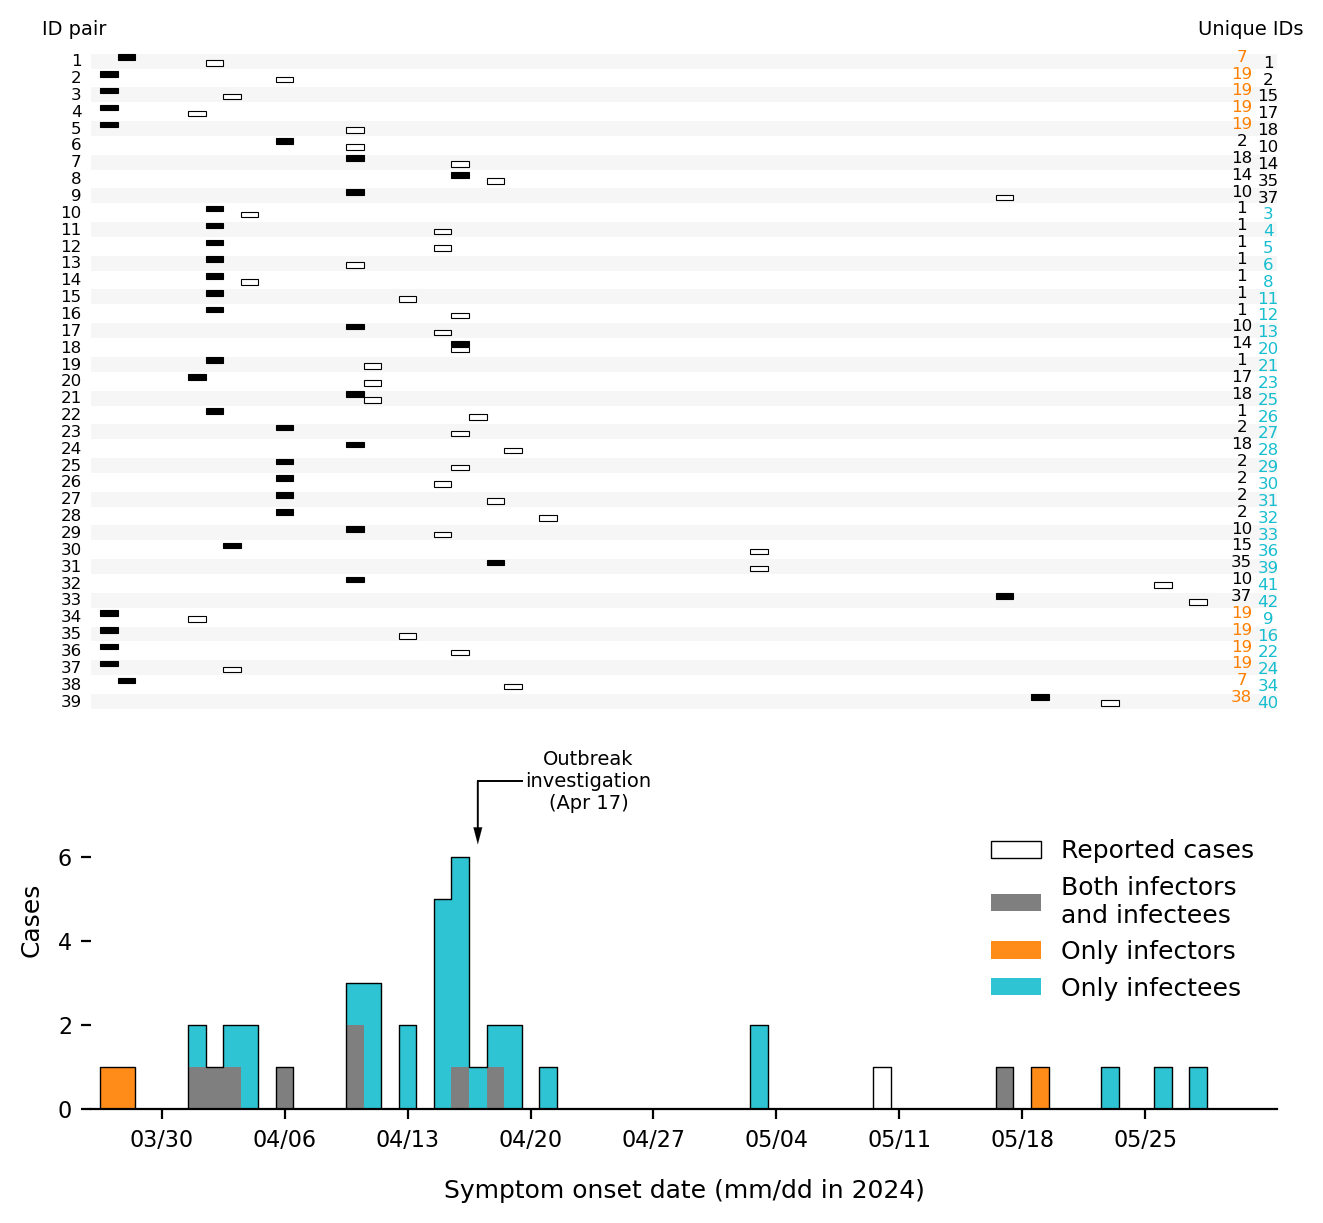

In [16]:
fig, (ax2, ax) = plt.subplots(2, 1, sharex=True, 
                              gridspec_kw={'height_ratios': [3, 1.7], 
                                           'hspace': 0.01})
fig.set_size_inches(6.5, 6); 

## First subplot
xmin = np.timedelta64(mindate_linelist - mindate_linelist, 'D').astype('int64') - 1
xmax = np.timedelta64(maxdate_linelist - mindate_linelist, 'D').astype('int64') + 1
bins_number = xmax - xmin + 2

df_ = df_linelist_ID_raw
df_['OnsetDay'] = (df_['Onset'] - mindate_linelist).dt.days
n_, edges = np.histogram(df_.OnsetDay.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-1] + 0.5, n_, lw = 0.5, step='pre', edgecolor='none', facecolor = 'w', 
                label = None)
ax.fill_between(edges[:-1] + 0.5, n_, lw = 0.5, step='pre', edgecolor='k', facecolor = 'none', 
                label = 'Reported cases', zorder=5)

df_ = df_both_infectors_and_infectees.merge(df_unique_IDs)
n_, edges = np.histogram(df_.OnsetDay.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-1] + 0.5, n_, lw = 0, step='pre', edgecolor='k', facecolor = 'C7', 
    label = 'Both infectors\nand infectees')

df_ = df_only_infectors.rename(columns = {'ID_infector': 'ID'}).merge(df_unique_IDs)
n2_, edges = np.histogram(df_.OnsetDay.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-1] + 0.5, n_ + n2_, n_, lw = 0, step='pre', edgecolor='k', alpha=.9, facecolor = '#ff7f00', 
    label = 'Only infectors')

df_ = df_only_infectees.rename(columns = {'ID_infectee': 'ID'}).merge(df_unique_IDs)
n3_, edges = np.histogram(df_.OnsetDay.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-1] + 0.5, n_ + n2_ + n3_, n_ + n2_, lw = 0, step='pre', edgecolor='k', alpha=.9, facecolor = 'C9', 
    label = 'Only infectees')

xstep = 5
xtks = np.arange(xmin - 3, xmax + 2, 7)
ax.set_xticks(xtks)
ax.set_xticklabels([(mindate_linelist + np.timedelta64(int(x),'D')).strftime("%m/%d") for x in xtks],fontsize=8);
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=8);

ax.set_xlabel('Symptom onset date (mm/dd in 2024)', fontsize = 9, labelpad = 10)
ax.set_ylabel('Cases', fontsize = 9, labelpad = 5)
plt.legend(frameon=False, fontsize = 9, ncol = 1, title = None, title_fontsize = 9, loc=5)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.axis('tight');
ax.set_yticks(np.arange(0, 8, 2));
ax.set_ylim(0, 9)
ax.set_xlim(xmin - .5, xmax - .5);

## Second subplot
df_ = df_linelist_ordered.copy()

ystep = 1
yheight = .4
y_ = 0.0
fct_ = 1.4
from matplotlib.patches import Polygon

ax2.text(-2, y_ + yheight * 7, "ID pair", color = "k",
         verticalalignment='center', horizontalalignment='center', fontsize = 7) 
ax2.text(xmax + 1, y_ + yheight * 7, "Unique IDs", color = "k",
         verticalalignment='center', horizontalalignment='center', fontsize = 7)

ytks = []; ytks_lbs = []
for idx in range(df_.shape[0]):
    record_ = df_.iloc[idx]
    if idx % 2 == 0:
        y_pair_ = y_ 
        pts = np.array([[xmin - 0.5, y_pair_ - fct_ * yheight * 2.1], [xmax + 5 - 0.5, y_pair_ - fct_ * yheight * 2.1], 
                        [xmax + 5 - 0.5, y_pair_ + fct_ * yheight * .6], [xmin - 0.5, y_pair_ + fct_ * yheight * .6]])
        ax2.add_patch(Polygon(pts, closed = True, edgecolor = 'none', facecolor = 'lightgray', alpha = .2, linewidth = .4, zorder = -20))

    for x in [1, 2]:
        x_L = record_[f'Onset{x}Day']
        x_R = record_[f'Onset{x}Day'] + 1
        y_pair_ = y_ - (x - 1) * yheight * 1.5
        pts = np.array([[x_L - 0.5, y_pair_ - fct_ * yheight / 2], [x_R - 0.5, y_pair_ - fct_ * yheight / 2], 
                        [x_R - 0.5, y_pair_ + fct_ * yheight / 2], [x_L - 0.5, y_pair_ + fct_ * yheight / 2]])
        ax2.add_patch(Polygon(pts, closed = True, edgecolor = 'k', facecolor = 'k' if x == 1 else 'w', alpha = 1, linewidth = .4))

    ax2.text(xmax + .5, y_, int(record_['ID_infector']), color = "#ff7f00" if record_['ID_infector'] not in both_infectors_and_infectees else 'k',
             verticalalignment='center', horizontalalignment='center', fontsize = 6) 
    ax2.text(xmax + 2, y_ - yheight * 1.5, int(record_['ID_infectee']), color = "C9" if record_['ID_infectee'] not in both_infectors_and_infectees else 'k',
             verticalalignment='center', horizontalalignment='center', fontsize = 6) 

    ytks = np.r_[ytks, [y_ - yheight * .75]]
    ytks_lbs = np.r_[ytks_lbs, [f'{idx + 1:d}']]

    y_ -= 1.7 * ystep
    
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.tick_params('both', length=0)
ax2.set_yticks(ytks)
ax2.set_yticklabels(ytks_lbs, fontsize = 6)
ax2.set_xlim(xmin, xmax + 2.5);
ax2.set_ylim(y_, ystep);

outbreak_recognition_date = pd.to_datetime("2024-04-17", format="%Y-%m-%d")
outbreak_recognition_day = (outbreak_recognition_date - mindate_linelist).days
yhead_arrow = 7.8
ax.arrow(outbreak_recognition_day, yhead_arrow, 0, -1.5, width = .1, color='k', linewidth = .05, 
         length_includes_head=True, head_width=.5, head_length = .4);
ax.plot([outbreak_recognition_day, outbreak_recognition_day + 2.5], [yhead_arrow] * 2, lw = .7, color='k');
ax.text(outbreak_recognition_day + 6.3, yhead_arrow, "Outbreak\ninvestigation\n(Apr 17)", fontsize = 7, 
        verticalalignment='center', horizontalalignment='center');

plt.savefig("../../figures/data_epicurve.pdf", format="pdf", bbox_inches="tight");

# Analysis of statistical modeling from Stan

## Incubation period

### Results of the simulations

#### Mixture model

In [119]:
model_ = 'mixture'
basename = f'incper-{model_}'
standirname = os.path.join(stansimsdir, basename)
print(basename)

incper-mixture


In [120]:
paths = [str(x) for x in list(pathlib.Path(standirname).glob("trace*.csv"))]
print(paths)
globals()[f'fit_incper_{model_}'] = cmdstan.from_csv(paths)
globals()[f'idata_incper_{model_}'] = az.from_cmdstanpy(
    posterior = globals()[f'fit_incper_{model_}'],
    posterior_predictive = ["q", "comp_incper",  "incper_pred"]
)
globals()[f'df_fit_incper_{model_}'] = get_stats(globals()[f'idata_incper_{model_}'].posterior, 
            ['mean_incper', 'sd_incper']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})
display(globals()[f'df_fit_incper_{model_}'])

['../../stan_sims/incper-mixture/trace-3.csv', '../../stan_sims/incper-mixture/trace-4.csv', '../../stan_sims/incper-mixture/trace-2.csv', '../../stan_sims/incper-mixture/trace-1.csv']


,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,mean_incper,NA,6.75330,1.07587,5.00263,6.04191,6.63266,7.31285,9.20801,5.25389,8.08616,8.65468,47464.97286,29386.04245,1.00016
1,sd_incper,NA,3.64712,1.44215,2.01106,2.74872,3.32576,4.13589,7.27534,2.16123,5.22803,6.16091,42971.01215,26034.31975,1.00003


In [121]:
get_stats(globals()[f'idata_incper_{model_}'].posterior_predictive, 
     ['incper_pred']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})

,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,incper_pred,NA,6.76785,4.29373,1.76042,4.15576,5.94591,8.34525,16.40675,2.27183,11.33464,13.78452,51745.39189,49736.18782,1.0


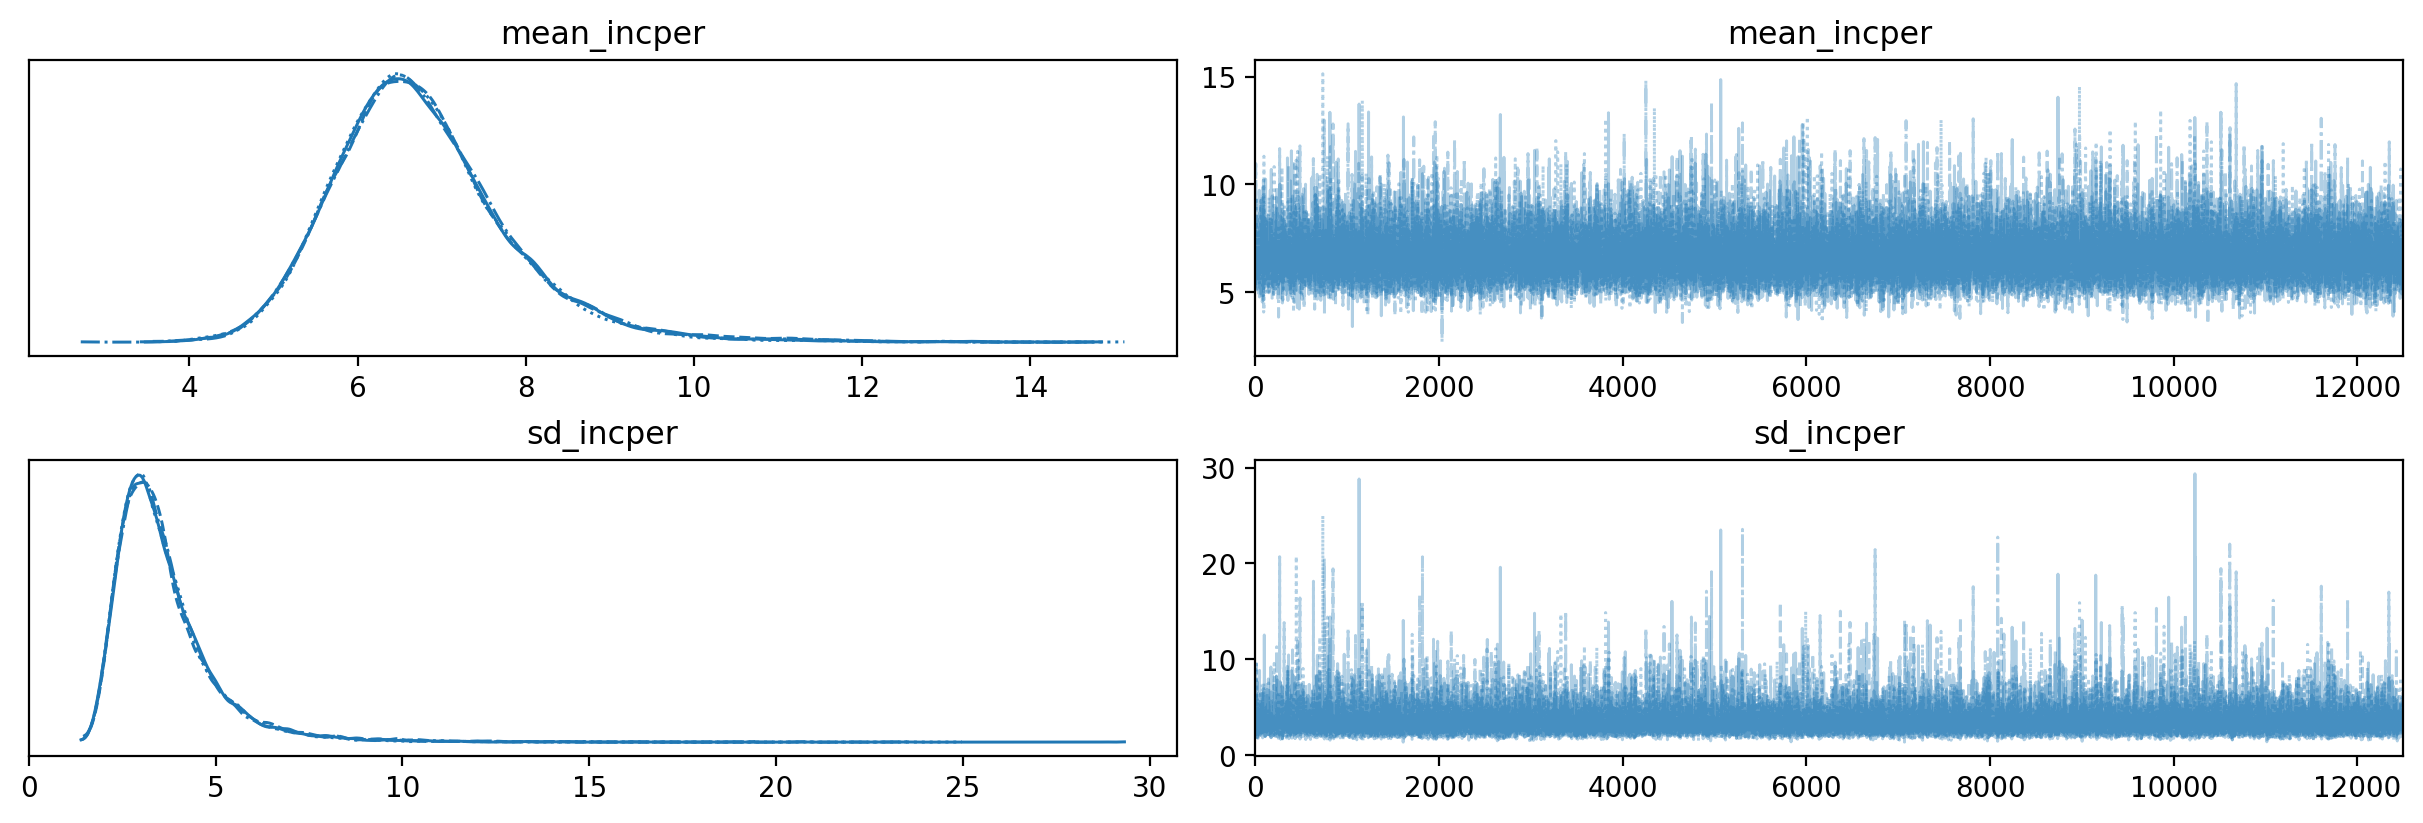

In [122]:
az.plot_trace(globals()[f'idata_incper_{model_}'].posterior, ['mean_incper', 'sd_incper']);

In [123]:
comp_incpers = globals()[f'idata_incper_{model_}'].posterior_predictive.comp_incper.values.flatten()
df_model_selection = pd.DataFrame({'incper': comp_incpers})
df_model_selection['n'] = 1

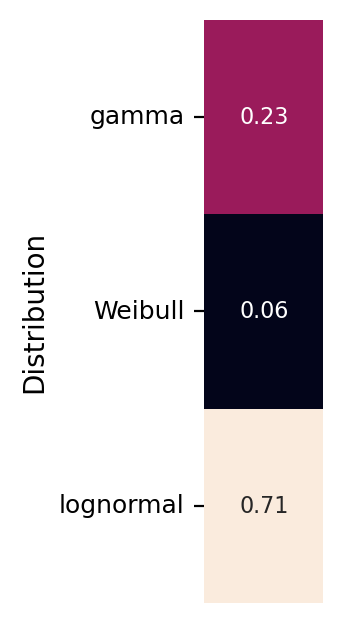

In [124]:
df_ = df_model_selection.groupby(['incper'])['n'].count().reset_index().astype('int').set_index('incper')
df_ = (df_ / df_.sum()).round(2)

fig, ax = plt.subplots()
fig.set_size_inches(1.6, 3); 
sns.heatmap(df_, annot=True, ax = ax, cbar = False, vmax = .5, annot_kws={"size": 8})
ax.set_yticks(np.arange(1, 4) - .5, ['gamma', 'Weibull', 'lognormal'], 
              rotation='horizontal', fontsize=9)
ax.set_ylabel('Distribution');
ax.set_xticks([]);

#### Lognormal distribution

In [125]:
model_ = 'lognormal'
basename = f'incper-{model_}'
standirname = os.path.join(stansimsdir, basename)
print(basename)

incper-lognormal


In [126]:
paths = [str(x) for x in list(pathlib.Path(standirname).glob("trace*.csv"))]
print(paths)
globals()[f'fit_incper_{model_}'] = cmdstan.from_csv(paths)
globals()[f'idata_incper_{model_}'] = az.from_cmdstanpy(
    posterior = globals()[f'fit_incper_{model_}'],
    posterior_predictive = ["incper_pred"]
)
globals()[f'df_fit_incper_{model_}'] = get_stats(globals()[f'idata_incper_{model_}'].posterior, 
            ['mean_incper', 'sd_incper']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})
display(globals()[f'df_fit_incper_{model_}'])

['../../stan_sims/incper-lognormal/trace-3.csv', '../../stan_sims/incper-lognormal/trace-4.csv', '../../stan_sims/incper-lognormal/trace-2.csv', '../../stan_sims/incper-lognormal/trace-1.csv']


,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,mean_incper,NA,7.33593,1.67481,5.06405,6.23822,7.00991,8.03646,11.64369,5.34349,9.38190,10.45061,47098.75927,28197.53462,1.00010
1,sd_incper,NA,5.60849,3.69126,2.25666,3.41040,4.52947,6.45917,15.77048,2.46088,9.55449,12.45863,41886.85544,26475.22190,1.00019


In [127]:
get_stats(globals()[f'idata_incper_{model_}'].posterior_predictive, 
     ['incper_pred']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})

,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,incper_pred,NA,7.35999,6.46254,1.43869,3.83634,5.83329,8.81806,22.57494,1.89496,13.28322,17.38742,51466.11351,49140.60648,1.00002


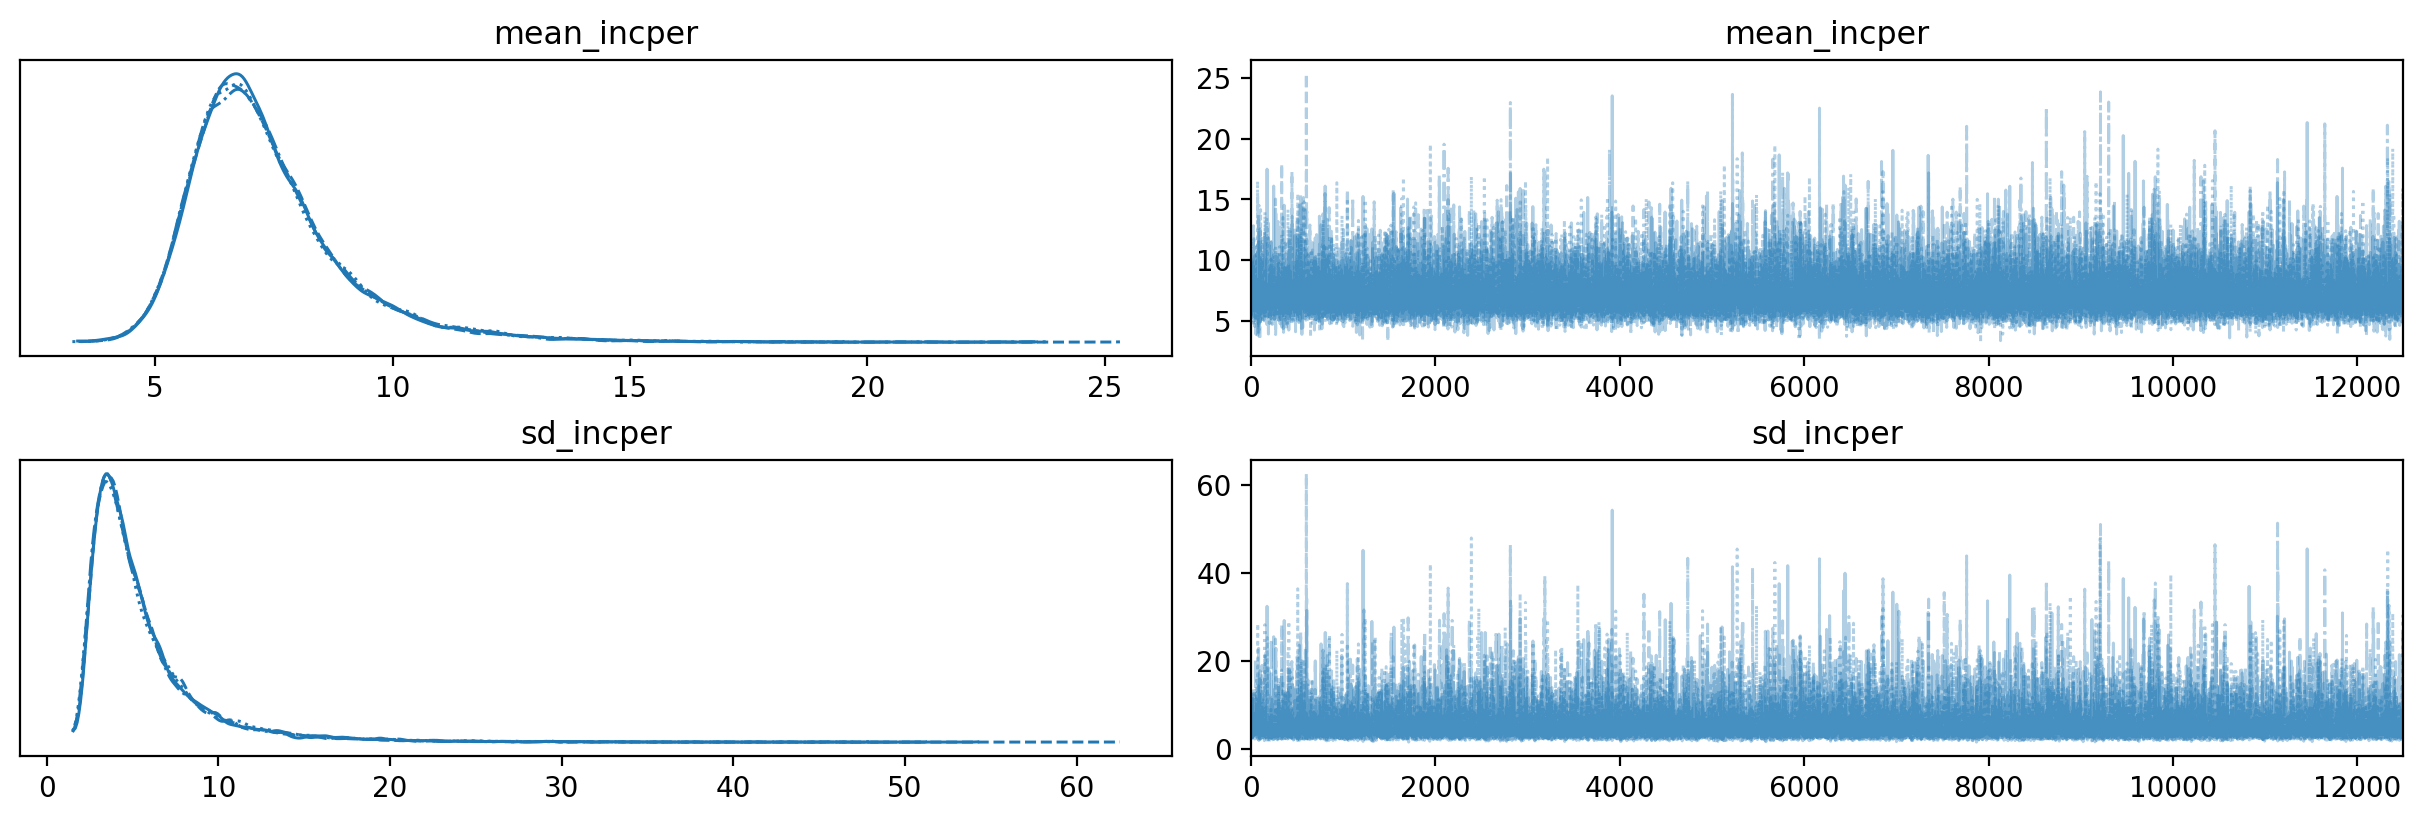

In [128]:
az.plot_trace(globals()[f'idata_incper_{model_}'].posterior, ['mean_incper', 'sd_incper']);

## Generation time

In [17]:
models_to_consider = [
    'gamma', 
    'weibull', 
    'lognormal', 
    'mixture', 
]

#### Mixture_observed model

In [18]:
model_ = 'mixture_observed'
basename = f'gentime-{model_}'
standirname = os.path.join(stansimsdir, basename)
print(basename)

gentime-mixture_observed


In [19]:
paths = [str(x) for x in list(pathlib.Path(standirname).glob("trace*.csv"))]
print(paths)
globals()[f'fit_{model_}'] = cmdstan.from_csv(paths)
globals()[f'idata_{model_}'] = az.from_cmdstanpy(
    posterior = globals()[f'fit_{model_}'],
    posterior_predictive = ["q", "comp_gentime", "gentime_pred", "serint_pred", "TOST_pred"]
)

globals()[f'df_fit_{model_}'] = get_stats(globals()[f'idata_{model_}'].posterior, 
                                     ['mean_gentime', 'sd_gentime', 
                                      'R0']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})
display(globals()[f'df_fit_{model_}'])

['../../stan_sims/gentime-mixture_observed/trace-3.csv', '../../stan_sims/gentime-mixture_observed/trace-4.csv', '../../stan_sims/gentime-mixture_observed/trace-2.csv', '../../stan_sims/gentime-mixture_observed/trace-1.csv']


,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,mean_gentime,NA,10.45113,1.81258,7.58024,9.22251,10.23650,11.41700,14.58868,7.95552,12.70443,13.63421,44253.57837,30292.57175,1.00005
1,sd_gentime,NA,10.42130,3.95720,6.23003,8.02145,9.45554,11.64932,20.33784,6.60274,14.71880,17.28476,36214.19598,23597.26290,1.00013
2,R0,NA,1.01075,0.38943,0.49203,0.74885,0.93615,1.18318,1.98231,0.54511,1.48733,1.71939,67651.11372,33159.74932,1.00000


In [20]:
get_stats(globals()[f'idata_{model_}'].posterior_predictive, 
     ['gentime_pred', 
      'serint_pred', 'TOST_pred']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})

,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,gentime_pred,NA,10.48833,11.08178,0.83732,3.96754,7.49582,13.32520,37.29922,1.32580,21.71002,28.98170,47497.20784,43783.42587,0.99996
1,serint_pred,NA,10.47651,11.44189,-1.66917,3.84366,7.87334,13.87650,37.60401,-0.41650,22.30896,29.48446,49677.87602,49307.71413,0.99996
2,TOST_pred,NA,3.14319,11.25676,-8.17248,-3.31151,0.36764,6.26302,30.00971,-7.03545,14.66966,21.96480,49374.90483,48684.13105,0.99995


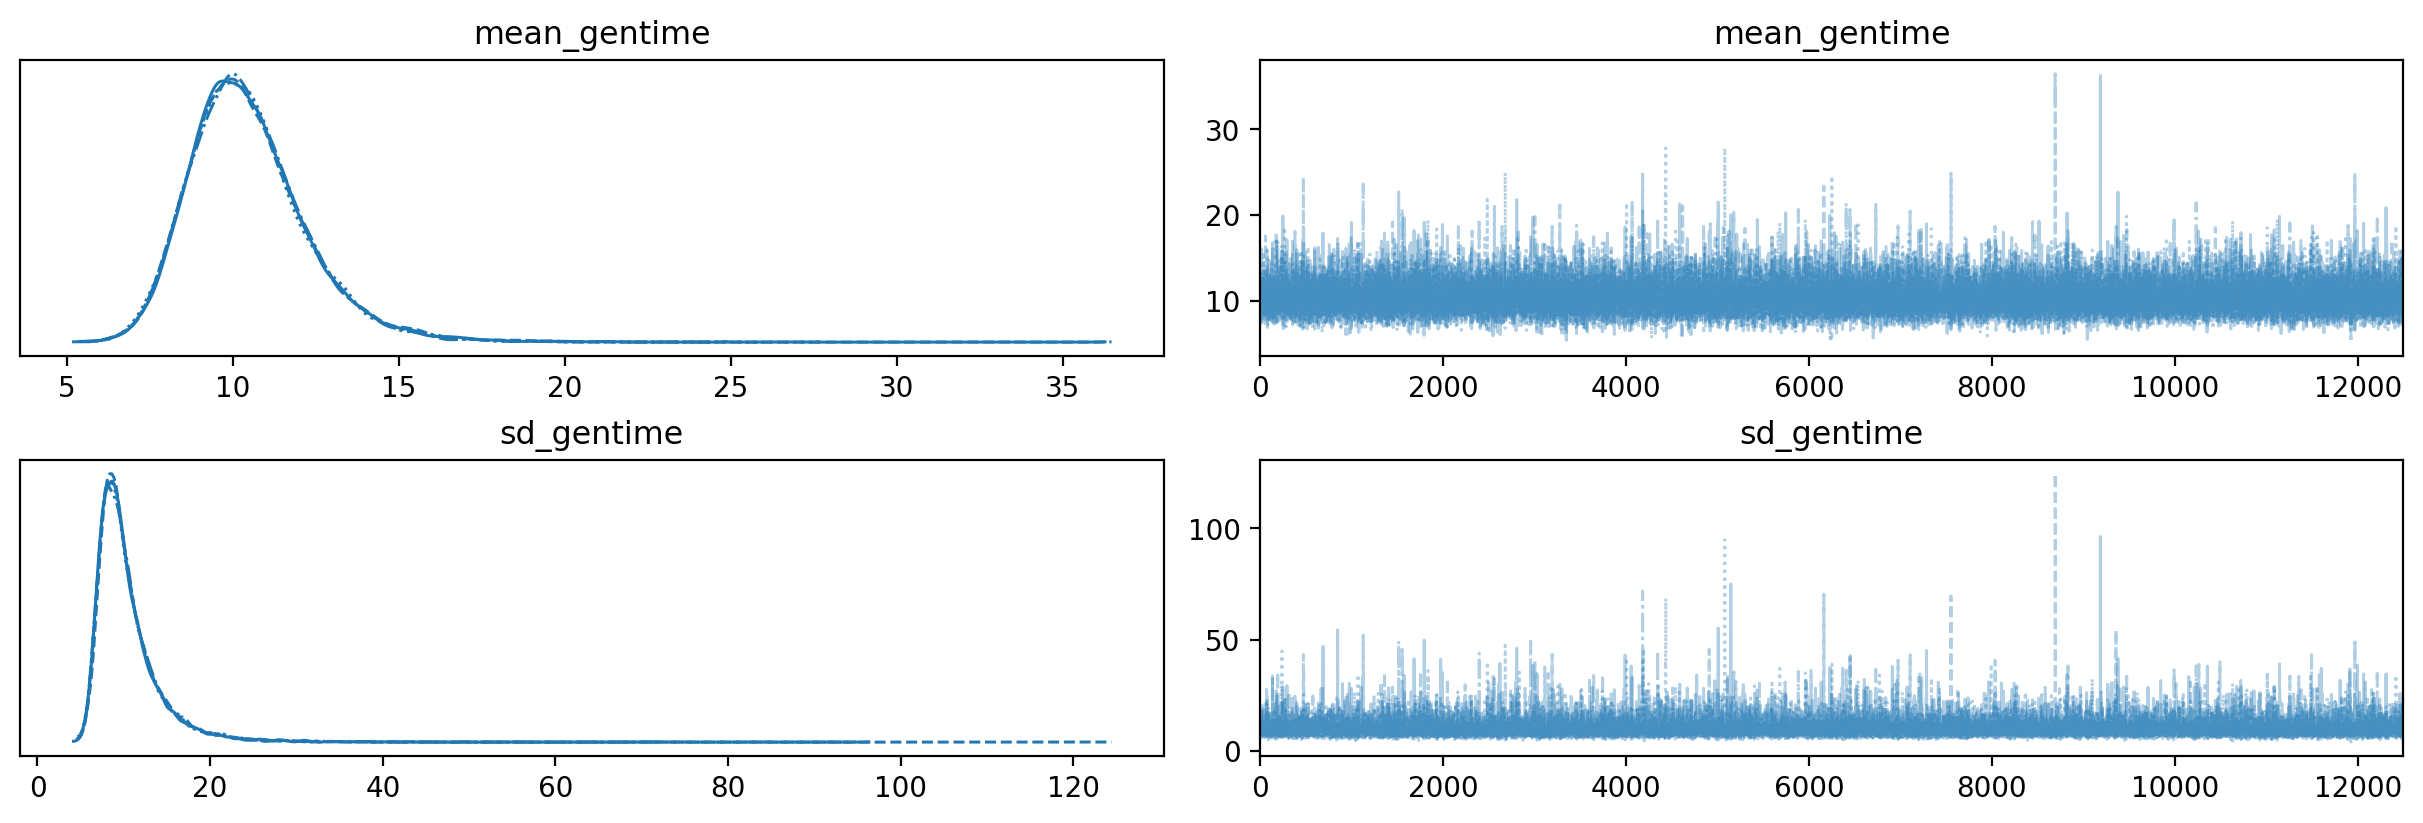

In [21]:
az.plot_trace(globals()[f'idata_{model_}'].posterior, ['mean_gentime', 'sd_gentime']);

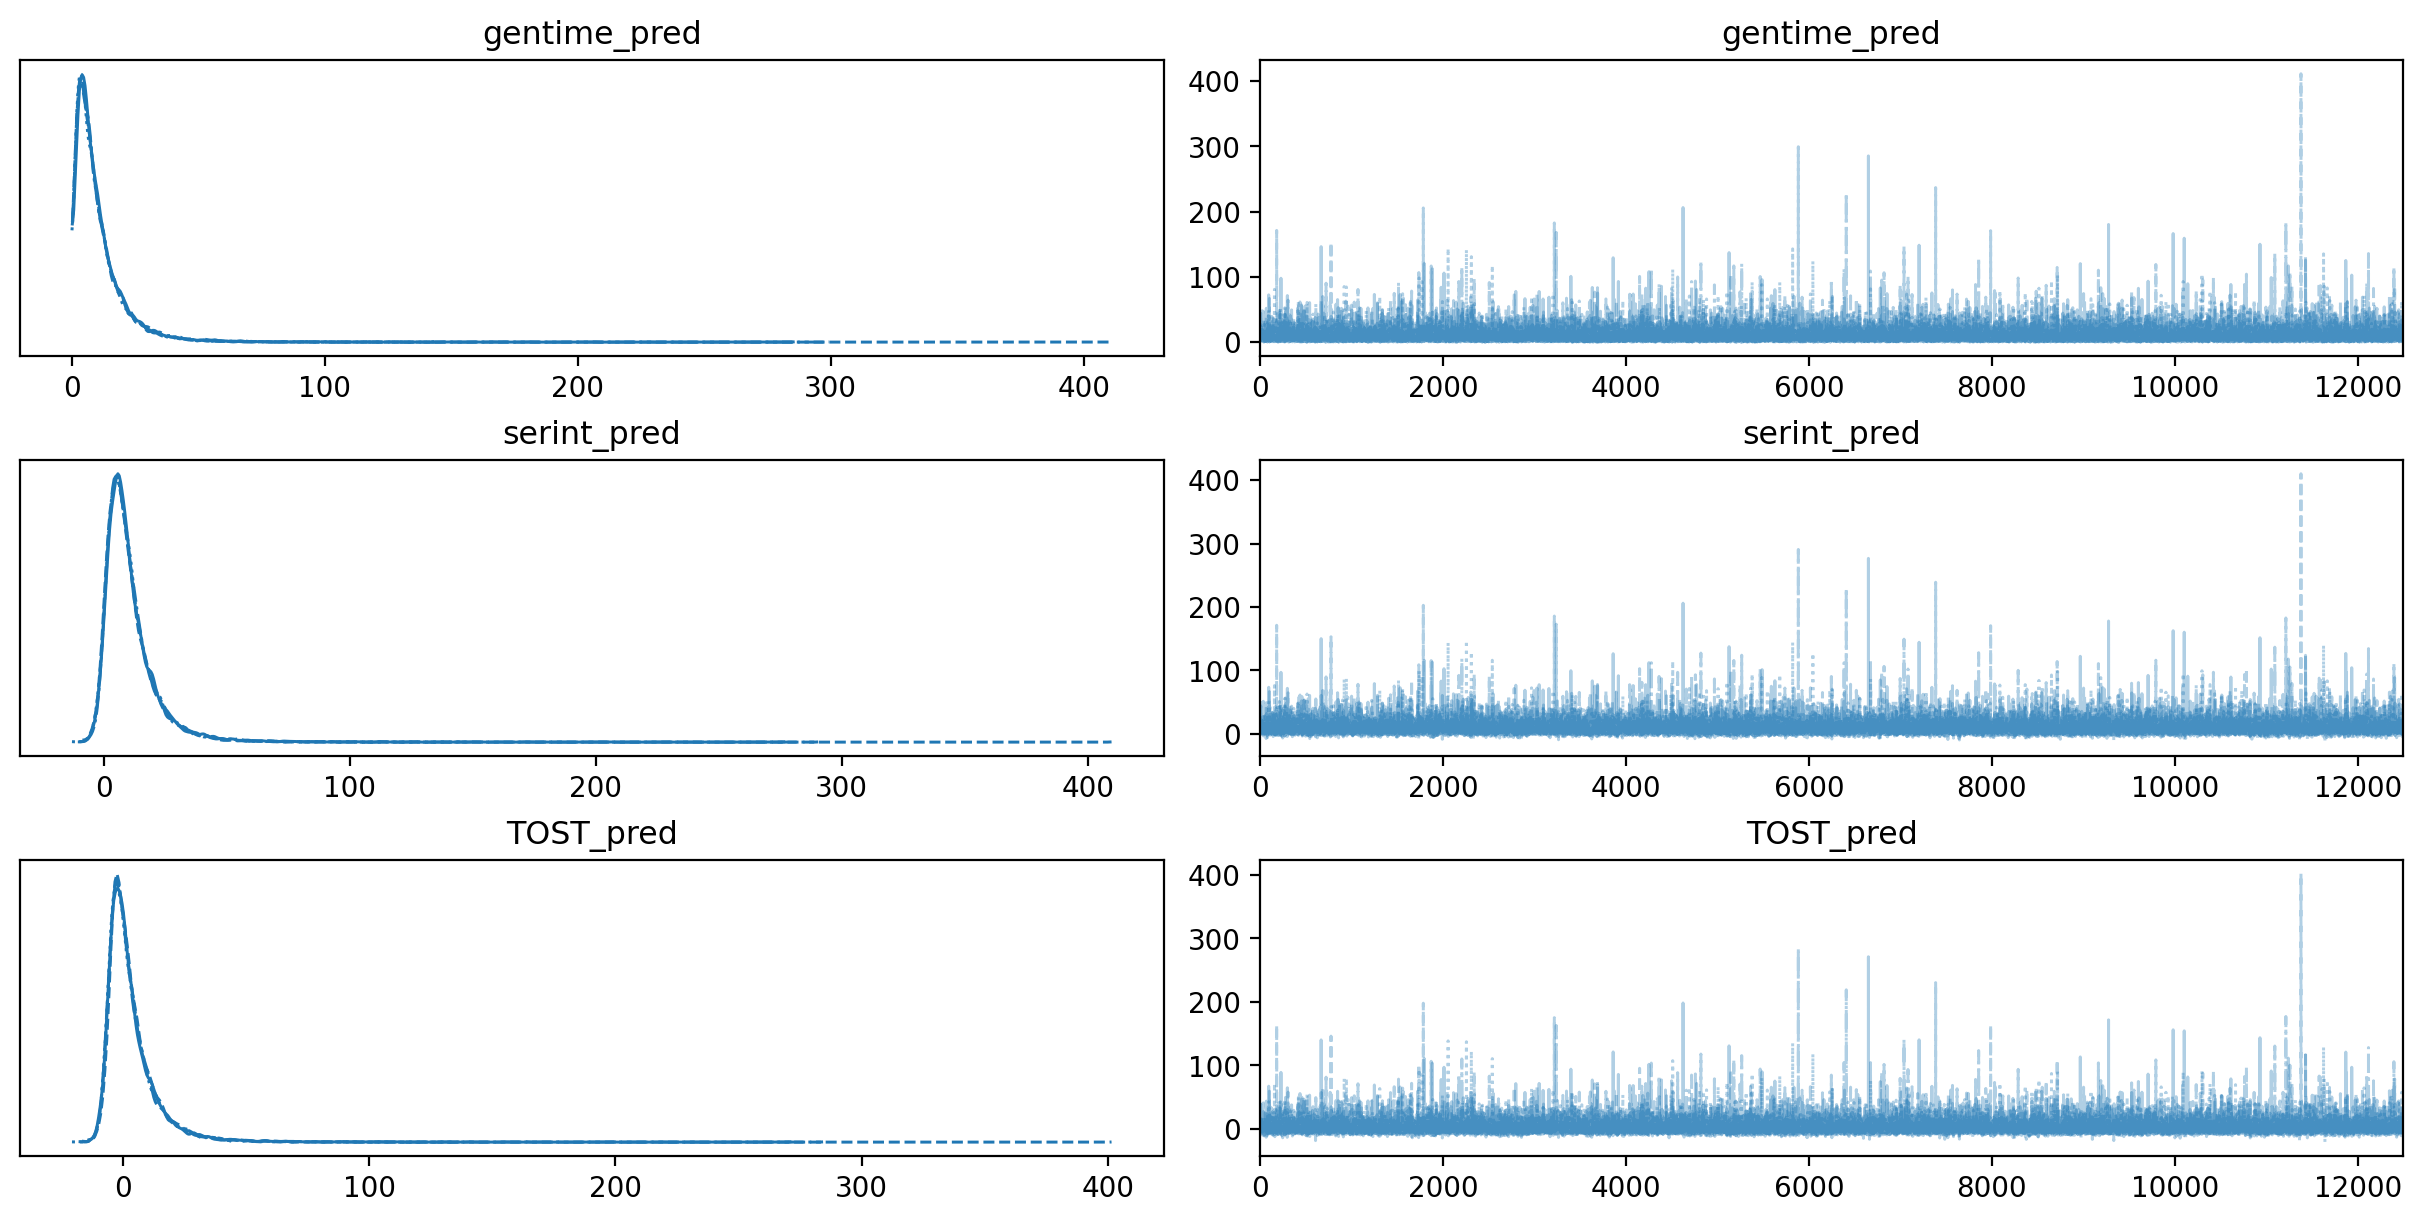

In [22]:
az.plot_trace(globals()[f'idata_{model_}'].posterior_predictive, ['gentime_pred', 'serint_pred', 'TOST_pred']);

In [23]:
comp_gentimes = globals()[f'idata_{model_}'].posterior_predictive.comp_gentime.values.flatten()
df_model_selection = pd.DataFrame({'gentime': comp_gentimes})
df_model_selection['n'] = 1

            n
gentime      
1        0.21
2        0.16
3        0.63


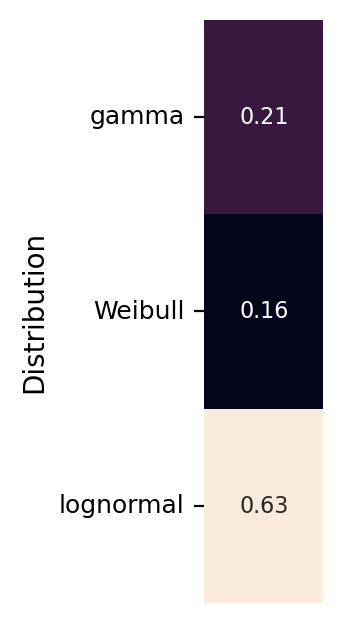

In [24]:
df_ = df_model_selection.groupby(['gentime'])['n'].count().reset_index().astype('int').set_index('gentime')
df_ = (df_ / df_.sum()).round(2)
print(df_)

fig, ax = plt.subplots()
fig.set_size_inches(1.6, 3); 
sns.heatmap(df_, annot=True, ax = ax, cbar = False, vmax = .5, annot_kws={"size": 8})
ax.set_yticks(np.arange(1, 4) - .5, ['gamma', 'Weibull', 'lognormal'], 
              rotation='horizontal', fontsize=9)
ax.set_ylabel('Distribution');
ax.set_xticks([]);

#### Mixture model

In [25]:
model_ = 'mixture'
basename = f'gentime-{model_}'
standirname = os.path.join(stansimsdir, basename)
print(basename)

gentime-mixture


In [26]:
paths = [str(x) for x in list(pathlib.Path(standirname).glob("trace*.csv"))]
print(paths)
globals()[f'fit_{model_}'] = cmdstan.from_csv(paths)
globals()[f'idata_{model_}'] = az.from_cmdstanpy(
    posterior = globals()[f'fit_{model_}'],
    posterior_predictive = ["q", "comp_gentime", "gentime_pred", "serint_pred", "TOST_pred", "R_t", "gentime_mean_t"]
)

globals()[f'idata_{model_}'].posterior['R1'] = globals()[f'idata_{model_}'].posterior.R0 * (1.0 - globals()[f'idata_{model_}'].posterior.epsilon)

globals()[f'df_fit_{model_}'] = get_stats(globals()[f'idata_{model_}'].posterior, 
                                     ['mean_gentime', 'sd_gentime', 
                                      'R0', 'epsilon', 'R1']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})
display(globals()[f'df_fit_{model_}'])

['../../stan_sims/gentime-mixture/trace-3.csv', '../../stan_sims/gentime-mixture/trace-4.csv', '../../stan_sims/gentime-mixture/trace-2.csv', '../../stan_sims/gentime-mixture/trace-1.csv']


,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,mean_gentime,NA,14.73884,5.14529,9.02429,11.66268,13.60730,16.34358,27.42743,9.58664,20.11872,23.59185,29634.85926,22666.16316,1.00015
1,sd_gentime,NA,16.72148,15.23303,7.39634,10.32913,13.05710,18.05578,48.43435,7.94976,26.89643,36.01868,24088.45896,18443.92019,1.00006
2,R0,NA,1.36712,0.51712,0.65209,1.01004,1.27385,1.61571,2.62530,0.72556,2.02063,2.31569,48659.87681,35766.67710,1.00005
3,epsilon,NA,0.64809,0.16373,0.26002,0.55079,0.67680,0.77179,0.88761,0.33029,0.83604,0.86580,38410.32400,32208.72805,1.00022
4,R1,NA,0.45202,0.22860,0.15443,0.29382,0.40473,0.55738,1.01503,0.18157,0.73733,0.87632,66624.84548,34544.67849,1.00011


In [27]:
get_stats(globals()[f'idata_{model_}'].posterior_predictive, 
     ['gentime_pred', 
      'serint_pred', 'TOST_pred']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})

,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,gentime_pred,NA,14.71724,23.67696,0.89681,4.81912,9.61135,18.13625,56.22240,1.46613,30.91168,42.43519,48168.59434,44442.29557,1.00005
1,serint_pred,NA,14.70372,23.83463,-1.23864,4.80163,9.94354,18.48030,56.79265,0.04823,31.23226,42.79553,47375.38014,47680.42003,1.00006
2,TOST_pred,NA,7.37053,23.74641,-7.79246,-2.42799,2.43100,10.98655,49.03303,-6.58745,23.79902,35.30151,48070.09771,47951.30959,1.00004


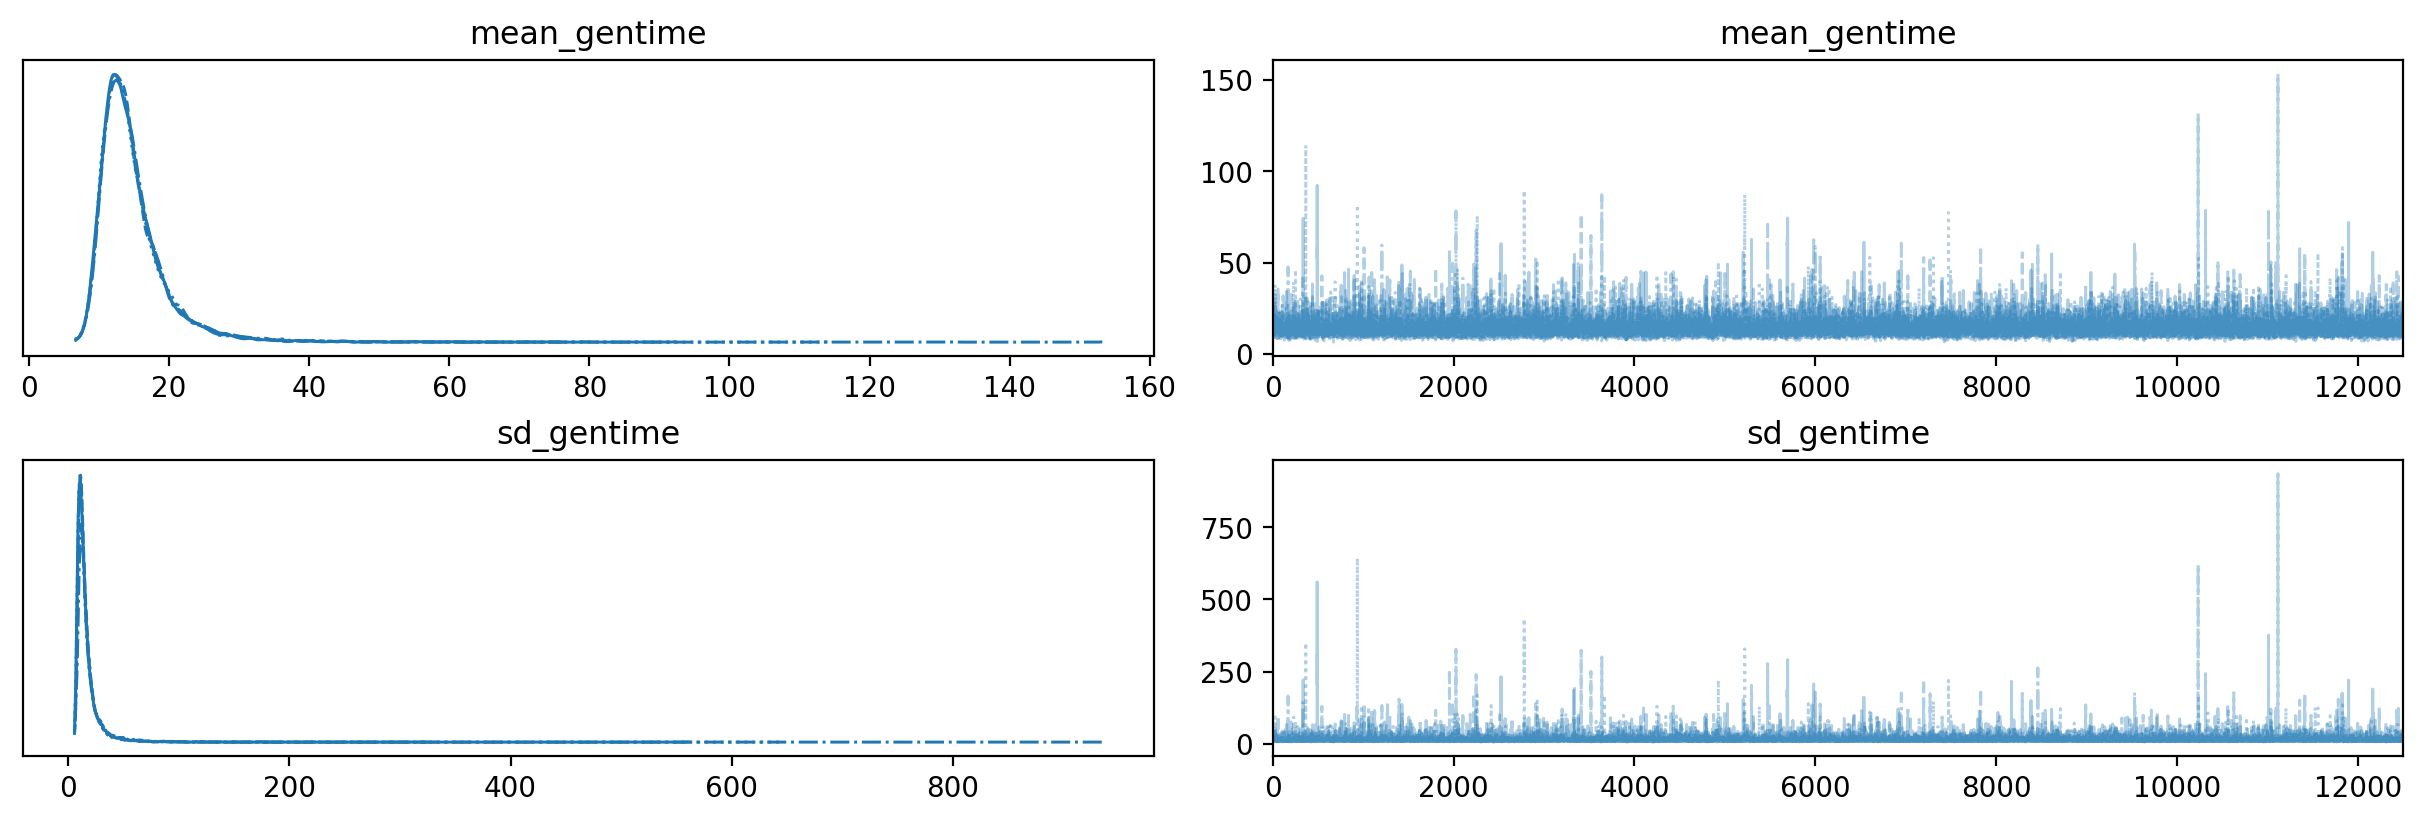

In [28]:
az.plot_trace(globals()[f'idata_{model_}'].posterior, ['mean_gentime', 'sd_gentime']);

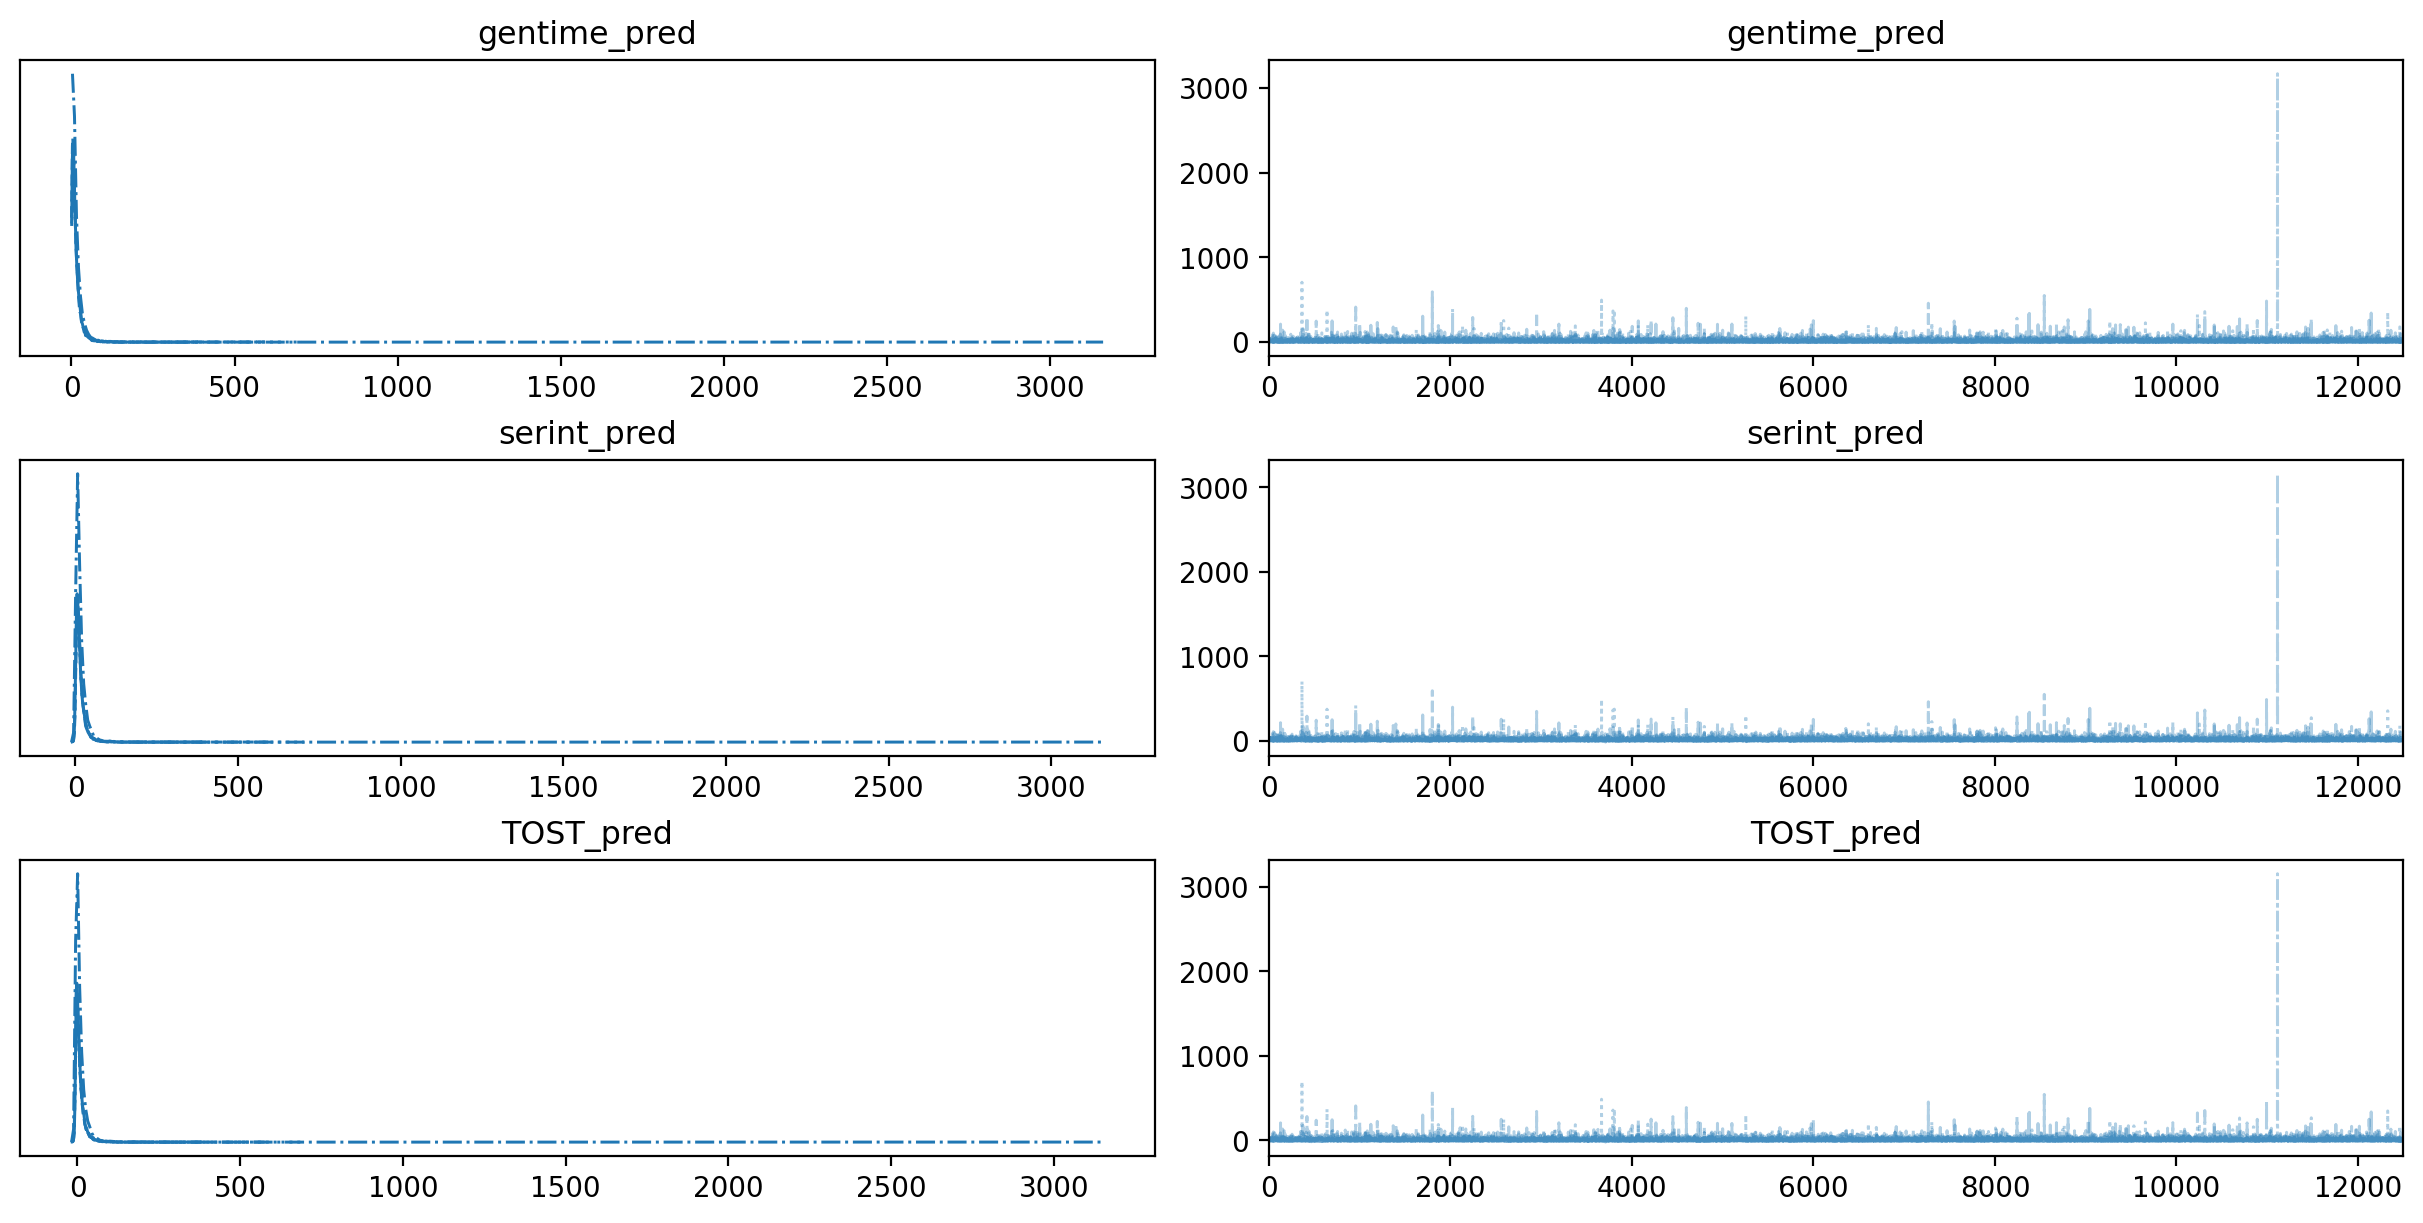

In [29]:
az.plot_trace(globals()[f'idata_{model_}'].posterior_predictive, ['gentime_pred', 'serint_pred', 'TOST_pred']);

In [30]:
comp_gentimes = globals()[f'idata_{model_}'].posterior_predictive.comp_gentime.values.flatten()
df_model_selection = pd.DataFrame({'gentime': comp_gentimes})
df_model_selection['n'] = 1

            n
gentime      
1        0.25
2        0.24
3        0.51


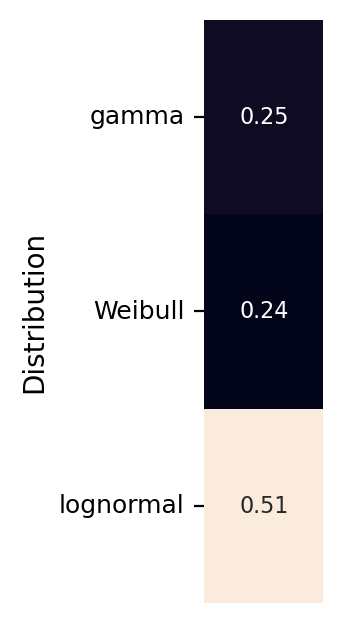

In [31]:
df_ = df_model_selection.groupby(['gentime'])['n'].count().reset_index().astype('int').set_index('gentime')
df_ = (df_ / df_.sum()).round(2)
print(df_)

fig, ax = plt.subplots()
fig.set_size_inches(1.6, 3); 
sns.heatmap(df_, annot=True, ax = ax, cbar = False, vmax = .5, annot_kws={"size": 8})
ax.set_yticks(np.arange(1, 4) - .5, ['gamma', 'Weibull', 'lognormal'], 
              rotation='horizontal', fontsize=9)
ax.set_ylabel('Distribution');
ax.set_xticks([]);

#### Gamma distribution

In [287]:
model_ = 'gamma'
basename = f'gentime-{model_}'
standirname = os.path.join(stansimsdir, basename)
print(basename)

gentime-gamma


In [288]:
paths = [str(x) for x in list(pathlib.Path(standirname).glob("trace*.csv"))]
print(paths)
globals()[f'fit_{model_}'] = cmdstan.from_csv(paths)
globals()[f'idata_{model_}'] = az.from_cmdstanpy(
    posterior = globals()[f'fit_{model_}'],
    posterior_predictive = ["incper_pred", "gentime_pred", 
      "serint_pred", "TOST_pred"]
)
globals()[f'df_fit_{model_}'] = get_stats(globals()[f'idata_{model_}'].posterior, 
                                     ['mean_gentime', 'sd_gentime', 'R0', 'epsilon']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})
display(globals()[f'df_fit_{model_}'])

['../../stan_sims/gentime-gamma/trace-4.csv', '../../stan_sims/gentime-gamma/trace-2.csv', '../../stan_sims/gentime-gamma/trace-1.csv']


,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,mean_gentime,NA,14.07443,3.86516,8.87578,11.46360,13.30770,15.78310,23.76966,9.44230,18.87760,21.16323,28236.69120,21922.53038,1.00033
1,sd_gentime,NA,13.12663,4.57717,7.53418,10.06008,12.08925,14.97490,24.75601,8.01531,18.70462,21.58472,23451.02831,21018.29662,1.00033
2,R0,NA,1.38393,0.53387,0.64707,1.01731,1.28356,1.64305,2.67763,0.72467,2.05311,2.35852,38620.52822,26942.12318,1.00010
3,epsilon,NA,0.65765,0.16082,0.27315,0.56270,0.68572,0.77926,0.89046,0.34670,0.84054,0.86975,32080.39965,27770.07519,1.00028


In [289]:
get_stats(globals()[f'idata_{model_}'].posterior_predictive, 
     ['incper_pred', 'gentime_pred', 
      'serint_pred', 'TOST_pred']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})

,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,incper_pred,1,7.33244,2.02661,4.16322,5.89532,7.06556,8.46122,12.04402,4.53243,9.99072,11.03750,37434.06423,37625.86744,0.99997
1,incper_pred,2,7.33559,2.00662,4.17430,5.88547,7.07716,8.48193,11.96662,4.54696,10.01222,11.01194,37392.62168,36630.07431,1.00003
2,gentime_pred,NA,14.10641,14.30803,0.44685,4.52604,9.99264,18.89630,51.32139,0.89054,31.20619,40.99335,35482.43242,35726.95714,1.00000
3,serint_pred,NA,14.10956,14.59905,-1.68514,4.56342,10.27925,19.27388,51.87694,-0.37924,31.39841,41.29208,35496.00908,35771.16869,1.00003
4,TOST_pred,NA,6.77396,14.46034,-8.23154,-2.72372,2.77099,11.75058,44.30793,-7.05123,23.88553,33.76047,35183.12221,35535.66823,1.00005


#### Weibull distribution

In [290]:
model_ = 'weibull'
basename = f'gentime-{model_}'
standirname = os.path.join(stansimsdir, basename)
print(basename)

gentime-weibull


In [291]:
paths = [str(x) for x in list(pathlib.Path(standirname).glob("trace*.csv"))]
print(paths)
globals()[f'fit_{model_}'] = cmdstan.from_csv(paths)
globals()[f'idata_{model_}'] = az.from_cmdstanpy(
    posterior = globals()[f'fit_{model_}'],
    posterior_predictive = ["incper_pred", "gentime_pred", 
      "serint_pred", "TOST_pred"]
)
globals()[f'df_fit_{model_}'] = get_stats(globals()[f'idata_{model_}'].posterior, 
                                     ['mean_gentime', 'sd_gentime', 'R0', 'epsilon', 'phi']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})
display(globals()[f'df_fit_{model_}'])

['../../stan_sims/gentime-weibull/trace-3.csv', '../../stan_sims/gentime-weibull/trace-4.csv', '../../stan_sims/gentime-weibull/trace-2.csv', '../../stan_sims/gentime-weibull/trace-1.csv']


09:52:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 2 divergent transitions (0.0%)
	Chain 4 had 1 divergent transitions (0.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,mean_gentime,NA,13.54858,3.70672,8.75298,11.16285,12.83855,15.04950,22.58433,9.28505,17.85250,20.09946,48382.94326,31717.18202,1.00011
1,sd_gentime,NA,12.44458,4.81992,7.34799,9.52311,11.30395,13.95055,24.33982,7.76834,17.60610,20.69329,43203.21236,30041.09159,1.00007
2,R0,NA,1.43098,0.55975,0.66957,1.04731,1.32728,1.69173,2.80169,0.74826,2.12529,2.44490,64188.65660,34310.57791,0.99999
3,epsilon,NA,0.60502,0.17485,0.21507,0.49130,0.63093,0.73982,0.87153,0.27510,0.81379,0.84749,53873.54624,36960.07137,1.00000
4,phi,NA,0.26552,0.11393,0.11074,0.18637,0.24361,0.32005,0.54713,0.12567,0.41070,0.47934,91106.64686,35302.81622,0.99999


In [292]:
get_stats(globals()[f'idata_{model_}'].posterior_predictive, 
     ['incper_pred', 'gentime_pred', 
      'serint_pred', 'TOST_pred']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})

,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,incper_pred,1,7.32677,2.00893,4.17104,5.89096,7.07512,8.47166,11.98372,4.52924,9.96781,10.99496,49550.61559,49556.47399,1.00006
1,incper_pred,2,7.32633,2.01682,4.15290,5.88878,7.07187,8.47395,11.95190,4.51455,9.98694,11.00283,50334.89784,49460.33436,1.00004
2,gentime_pred,NA,13.54809,13.85374,0.43539,4.33198,9.76654,18.34637,47.92707,0.86798,29.57505,38.44738,50143.56889,47757.01303,1.00007
3,serint_pred,NA,13.54766,14.15643,-1.81506,4.40584,10.02190,18.69220,48.42078,-0.52053,29.98841,38.73854,49917.74564,46772.57728,1.00003
4,TOST_pred,NA,6.22132,13.99255,-8.31385,-2.87254,2.56442,11.16008,40.74855,-7.14526,22.37835,31.26861,49903.78295,48000.01280,1.00004


#### Lognormal distribution

In [293]:
model_ = 'lognormal'
basename = f'gentime-{model_}'
standirname = os.path.join(stansimsdir, basename)
print(basename)

gentime-lognormal


In [294]:
paths = [str(x) for x in list(pathlib.Path(standirname).glob("trace*.csv"))]
print(paths)
globals()[f'fit_{model_}'] = cmdstan.from_csv(paths)
globals()[f'idata_{model_}'] = az.from_cmdstanpy(
    posterior = globals()[f'fit_{model_}'],
    posterior_predictive = ["incper_pred", "gentime_pred", 
      "serint_pred", "TOST_pred"]
)
globals()[f'df_fit_{model_}'] = get_stats(globals()[f'idata_{model_}'].posterior, 
                                     ['mean_gentime', 'sd_gentime',
                                      'R0', 'epsilon', 'phi']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})
display(globals()[f'df_fit_{model_}'])

['../../stan_sims/gentime-lognormal/trace-4.csv', '../../stan_sims/gentime-lognormal/trace-2.csv', '../../stan_sims/gentime-lognormal/trace-1.csv']


,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,mean_gentime,NA,17.86226,7.28200,9.61664,13.03282,16.02085,20.55050,36.41084,10.29504,26.76948,31.62509,18197.59055,18901.65565,1.00012
1,sd_gentime,NA,28.10254,20.42046,9.30612,15.58110,22.17520,33.43218,82.19309,10.38720,50.87985,65.65782,16189.29347,18014.71181,1.00020
2,R0,NA,1.39367,0.53710,0.65753,1.01860,1.29787,1.64998,2.70346,0.73053,2.07578,2.38387,30677.29180,27219.75548,1.00012
3,epsilon,NA,0.65983,0.16213,0.27190,0.56432,0.68838,0.78302,0.89234,0.34346,0.84470,0.87253,27152.68726,24542.98150,1.00031
4,phi,NA,0.31004,0.14199,0.12347,0.21189,0.28150,0.37528,0.66485,0.14029,0.48758,0.57371,39309.71859,26147.93397,0.99999


In [295]:
get_stats(globals()[f'idata_{model_}'].posterior_predictive, 
     ['incper_pred', 'gentime_pred', 
      'serint_pred', 'TOST_pred']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})

,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,incper_pred,1,7.34215,2.01906,4.16298,5.89926,7.07047,8.50488,11.99384,4.52106,10.03473,11.04513,36855.37023,37155.98806,0.99997
1,incper_pred,2,7.33779,2.02342,4.16750,5.89265,7.06688,8.49255,12.00525,4.52446,10.02400,11.03829,36696.54053,37021.12961,1.00011
2,gentime_pred,NA,17.72243,32.49611,1.13174,4.67090,9.46649,19.42818,82.77194,1.61548,37.88409,57.67765,37171.63429,35544.19198,1.00004
3,serint_pred,NA,17.71806,32.63117,-1.28037,4.68883,9.85690,19.66822,83.15654,0.08603,38.11701,57.80452,36868.55042,35412.64865,1.00003
4,TOST_pred,NA,10.38027,32.55770,-7.78067,-2.52162,2.34119,12.18530,75.80270,-6.61292,30.62507,50.34230,36533.23348,35816.16674,1.00002


### Figures

#### Figure 1 (variant with original estimate of Cho _et al._)

In [296]:
mean_Weibull_Cho2025 = 9.45
sd_Weibull_Cho2025 = 1.61

# via: https://github.com/scipy/scipy/issues/12134
from scipy.special import gamma, gammaln
from scipy.optimize import fsolve
def _h(c):
    r = np.exp(gammaln(2/c) - 2*gammaln(1/c))
    return np.sqrt(1/(2*c*r - 1))
def weibull_c_scale_from_mean_std(mean, std):
    c0 = 1.27 * np.sqrt(mean/std)
    c, info, ier, msg = fsolve(lambda t: _h(t) - (mean/std), c0, xtol=1e-10,
                               full_output=True)
    if ier != 1:
        raise RuntimeError(f'with mean={mean} and std={std}, '
                           f'fsolve failed: {msg}')
    c = c[0]
    scale = mean / gamma(1 + 1/c)
    return c, scale

param1_Weibull_Cho2025, param2_Weibull_Cho2025 = weibull_c_scale_from_mean_std(mean_Weibull_Cho2025, sd_Weibull_Cho2025)
param1_Weibull_Cho2025, param2_Weibull_Cho2025

(np.float64(6.896113005396842), np.float64(10.110108788630068))

In [297]:
from scipy.stats import weibull_min
weibull_dist_Cho2025 = weibull_min(c=param1_Weibull_Cho2025, scale=param2_Weibull_Cho2025)
weibull_dist_Cho2025.ppf(0.75)

np.float64(10.600495806847722)

In [298]:
df_ChoAdjusted = get_stats(idata_mixture.posterior_predictive, 
    ['serint_pred']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'}).drop('time', axis=1)
np.transpose(df_ChoAdjusted)

,0
var,serint_pred
mean,15.29779
sd,24.97139
lower,-0.25422
IQR_lower,5.24551
median,10.45145
IQR_upper,19.07085
upper,57.34642
q5,0.87914
q90,31.85331


In [299]:
df_ChoAdjusted#.loc[lambda d: d['var']=='median']

,var,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat
0,serint_pred,15.29779,24.97139,-0.25422,5.24551,10.45145,19.07085,57.34642,0.87914,31.85331,43.50693,50309.06979,47992.40359,1.00001


In [300]:
df_study_comparison = pd.DataFrame({
    'study': ['Cho et al. 2025\nNon-adj.', 'Present study\nAdj.', 'te Beest et al. 2014\nEmpirical distr.'],
    'median': [weibull_dist_Cho2025.ppf(0.5), 
              df_ChoAdjusted.loc[:,'median'].values[0], 
              18.0],
    'q5': [weibull_dist_Cho2025.ppf(0.05), 
              df_ChoAdjusted.loc[:,'q5'].values[0], 
              3.3],
    'q25': [weibull_dist_Cho2025.ppf(0.25), 
              df_ChoAdjusted.loc[:,'IQR_lower'].values[0], 
              10.5],
    'q75': [weibull_dist_Cho2025.ppf(0.75), 
              df_ChoAdjusted.loc[:,'IQR_upper'].values[0], 
              28.5],
    'q95': [weibull_dist_Cho2025.ppf(0.95), 
              df_ChoAdjusted.loc[:,'q95'].values[0], 
              44.1],
    'mean': [mean_Weibull_Cho2025, 
              df_ChoAdjusted.loc[:,'mean'].values[0], 
              20.5],
})
df_study_comparison

,study,median,q5,q25,q75,q95,mean
0,Cho et al. 2025\nNon-adj.,9.586809,6.572078,8.439043,10.600496,11.853679,9.45000
1,Present study\nAdj.,10.451450,0.879140,5.245510,19.070850,43.506930,15.29779
2,te Beest et al. 2014\nEmpirical distr.,18.000000,3.300000,10.500000,28.500000,44.100000,20.50000


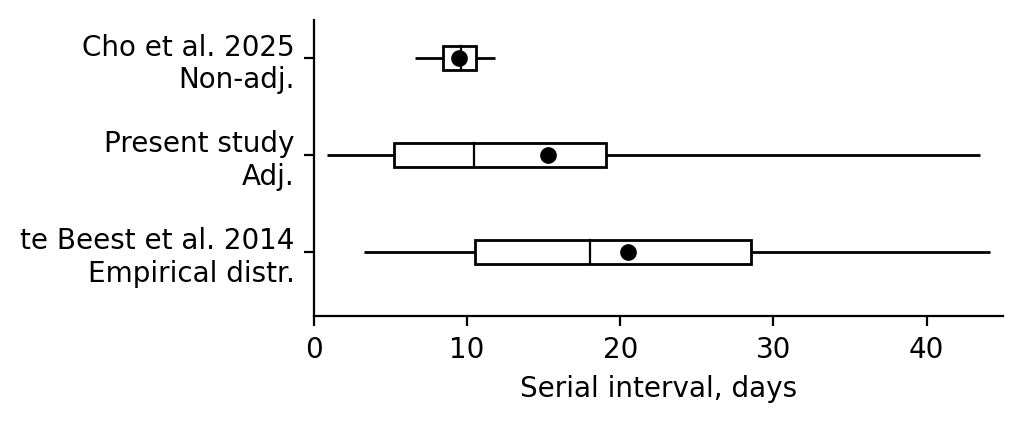

In [301]:
# for presentation
fig = plt.figure(figsize = [5, 2]) 
ax1 = fig.add_subplot()

df_ = df_study_comparison[::-1].copy()
df_['y'] = [(1.5 * i + 1) / df_.shape[0] for i in range(df_.shape[0])]

ax1.errorbar(x = list(df_['median']), y = df_['y'], 
             xerr = [list(df_['median'] - df_['q5']), 
                 list(df_['q95'] - df_['median'])], color = 'k',
             zorder = -10,
             capsize = 0, linestyle = 'None', linewidth=1, markersize=0)

yheight = .125
for record_id in range(df_.shape[0]):
    x_L = df_['q25'].values[record_id]
    x_R = df_['q75'].values[record_id]
    x_median = df_['median'].values[record_id]
    y_ = df_['y'].values[record_id]
    pts = np.array([[x_L, y_ + yheight / 2], [x_R, y_ + yheight / 2], 
                    [x_R, y_ - yheight / 2], [x_L, y_ - yheight / 2]])
    ax1.add_patch(Polygon(pts, closed = True, edgecolor = 'k', facecolor = 'w'))
    ax1.plot([x_median]*2, [y_ - yheight / 2, y_ + yheight / 2], color = 'k', lw = .8)

ax1.plot(list(df_['mean']), df_['y'], color='k', mfc='k', 
         linestyle='None', marker="o", ms=5)



ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(left = 0, right = 45)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()

ax1.set_yticks(df_['y'])
ax1.set_yticklabels(df_['study'])
ax1.set_ylim(0, np.max(df_['y'])+.2)

ax1.set_xlabel('Serial interval, days')

plt.savefig(f"{figuresdir}/SI_estimates_with_original.pdf", format="pdf", bbox_inches="tight")

plt.show()

#### Figure 1

In [32]:
df_ChoAdjusted = get_stats(idata_mixture.posterior_predictive, 
    ['serint_pred']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'}).drop('time', axis=1)

df_ChoUnadjusted = get_stats(idata_mixture_observed.posterior_predictive, 
    ['serint_pred']).rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'}).drop('time', axis=1)
np.transpose(df_ChoAdjusted), np.transpose(df_ChoUnadjusted)

(                     0
 var        serint_pred
 mean          14.70372
 sd            23.83463
 lower         -1.23864
 IQR_lower      4.80163
 median         9.94354
 IQR_upper      18.4803
 upper         56.79265
 q5             0.04823
 q90           31.23226
 q95           42.79553
 ess_bulk   47375.38014
 ess_tail   47680.42003
 r_hat          1.00006,
                      0
 var        serint_pred
 mean          10.47651
 sd            11.44189
 lower         -1.66917
 IQR_lower      3.84366
 median         7.87334
 IQR_upper      13.8765
 upper         37.60401
 q5             -0.4165
 q90           22.30896
 q95           29.48446
 ess_bulk   49677.87602
 ess_tail   49307.71413
 r_hat          0.99996)

In [33]:
df_study_comparison = pd.DataFrame({
    'study': ['Observed SI', 'Unmitigated SI', 'Empirical SI\nte Beest et al. 2014\n'],
    'median': [df_ChoUnadjusted.loc[:,'median'].values[0], 
              df_ChoAdjusted.loc[:,'median'].values[0], 
              18.0],
    'q5': [df_ChoUnadjusted.loc[:,'q5'].values[0], 
              df_ChoAdjusted.loc[:,'q5'].values[0], 
              3.3],
    'q25': [df_ChoUnadjusted.loc[:,'IQR_lower'].values[0], 
              df_ChoAdjusted.loc[:,'IQR_lower'].values[0], 
              10.5],
    'q75': [df_ChoUnadjusted.loc[:,'IQR_upper'].values[0], 
              df_ChoAdjusted.loc[:,'IQR_upper'].values[0], 
              28.5],
    'q95': [df_ChoUnadjusted.loc[:,'q95'].values[0], 
              df_ChoAdjusted.loc[:,'q95'].values[0], 
              44.1],
    'mean': [df_ChoUnadjusted.loc[:,'mean'].values[0], 
              df_ChoAdjusted.loc[:,'mean'].values[0], 
              20.5],
})
df_study_comparison

,study,median,q5,q25,q75,q95,mean
0,Observed SI,7.87334,-0.41650,3.84366,13.8765,29.48446,10.47651
1,Unmitigated SI,9.94354,0.04823,4.80163,18.4803,42.79553,14.70372
2,Empirical SI\nte Beest et al. 2014\n,18.00000,3.30000,10.50000,28.5000,44.10000,20.50000


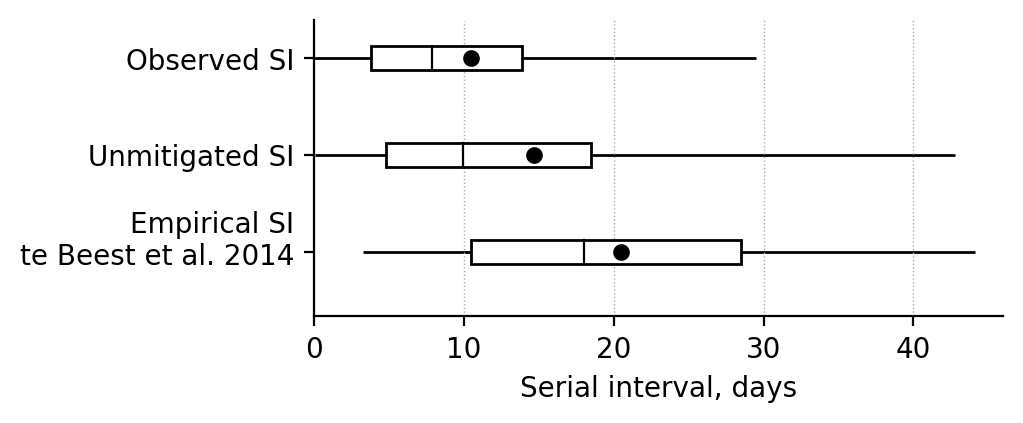

In [34]:
# for presentation
fig = plt.figure(figsize = [5, 2]) 
ax1 = fig.add_subplot()

df_ = df_study_comparison[::-1].copy()
df_['y'] = [(1.5 * i + 1) / df_.shape[0] for i in range(df_.shape[0])]

ax1.errorbar(x = list(df_['median']), y = df_['y'], 
             xerr = [list(df_['median'] - df_['q5']), 
                 list(df_['q95'] - df_['median'])], color = 'k',
             zorder = -10,
             capsize = 0, linestyle = 'None', linewidth=1, markersize=0)

yheight = .125
for record_id in range(df_.shape[0]):
    x_L = df_['q25'].values[record_id]
    x_R = df_['q75'].values[record_id]
    x_median = df_['median'].values[record_id]
    y_ = df_['y'].values[record_id]
    pts = np.array([[x_L, y_ + yheight / 2], [x_R, y_ + yheight / 2], 
                    [x_R, y_ - yheight / 2], [x_L, y_ - yheight / 2]])
    ax1.add_patch(Polygon(pts, closed = True, edgecolor = 'k', facecolor = 'w'))
    ax1.plot([x_median]*2, [y_ - yheight / 2, y_ + yheight / 2], color = 'k', lw = .8)

ax1.plot(list(df_['mean']), df_['y'], color='k', mfc='k', 
         linestyle='None', marker="o", ms=5)


ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(left = 0, right = 46)

xtks = np.arange(0, 50, 10)
ax1.set_xticks(xtks)
for xtk in xtks:
    ax1.vlines(xtk, 0, ax1.get_ylim()[-1], color='darkgrey', linestyle=':', lw=.5, zorder=-5)


ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()

ax1.set_yticks(df_['y'])
ax1.set_yticklabels(df_['study'])
ax1.set_ylim(0, np.max(df_['y'])+.2)

ax1.set_xlabel('Serial interval, days')

plt.savefig(f"{figuresdir}/SI_estimates.pdf", format="pdf", bbox_inches="tight")

plt.show()

#### Figure 2

In [88]:
df_variation_in_time = get_stats(idata_mixture.posterior_predictive, ["R_t", "gentime_mean_t"])\
    .rename(columns = {'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})
df_variation_in_time['date'] = [mindate_list + pd.DateOffset(days = x - preceeding_time) for x in df_variation_in_time.loc[:, 'time'].values]
df_variation_in_time

,var,time,mean,sd,lower,IQR_lower,median,IQR_upper,upper,q5,q90,q95,ess_bulk,ess_tail,r_hat,date
0,R_t,1,1.32949,0.48963,0.64437,0.99116,1.24420,1.56817,2.51806,0.71577,1.94831,2.22754,51899.11589,35662.14721,1.00004,2024-02-27
1,R_t,2,1.32770,0.48850,0.64389,0.99016,1.24278,1.56582,2.51408,0.71509,1.94552,2.22273,52022.60667,35414.60347,1.00004,2024-02-28
2,R_t,3,1.32579,0.48730,0.64318,0.98926,1.24142,1.56347,2.51023,0.71465,1.94194,2.21819,52151.37114,35330.43879,1.00003,2024-02-29
3,R_t,4,1.32375,0.48604,0.64241,0.98815,1.23970,1.56109,2.50563,0.71400,1.93816,2.21383,52291.41396,35456.92662,1.00004,2024-03-01
4,R_t,5,1.32158,0.48471,0.64197,0.98701,1.23778,1.55856,2.49804,0.71346,1.93390,2.20958,52438.46588,35542.22121,1.00004,2024-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,gentime_mean_t,90,14.73884,5.14529,9.02429,11.66268,13.60730,16.34358,27.42743,9.58664,20.11872,23.59185,29634.85926,22666.16316,1.00015,2024-05-26
184,gentime_mean_t,91,14.73884,5.14529,9.02429,11.66268,13.60730,16.34358,27.42743,9.58664,20.11872,23.59185,29634.85926,22666.16316,1.00015,2024-05-27
185,gentime_mean_t,92,14.73884,5.14529,9.02429,11.66268,13.60730,16.34358,27.42743,9.58664,20.11872,23.59185,29634.85926,22666.16316,1.00015,2024-05-28
186,gentime_mean_t,93,14.73884,5.14529,9.02429,11.66268,13.60730,16.34358,27.42743,9.58664,20.11872,23.59185,29634.85926,22666.16316,1.00015,2024-05-29


In [89]:
preceeding_time = 30
mindate_list = pd.to_datetime("2024-03-27", format = "%Y-%m-%d")
date_intervention = pd.to_datetime("2024-04-17", format = "%Y-%m-%d")

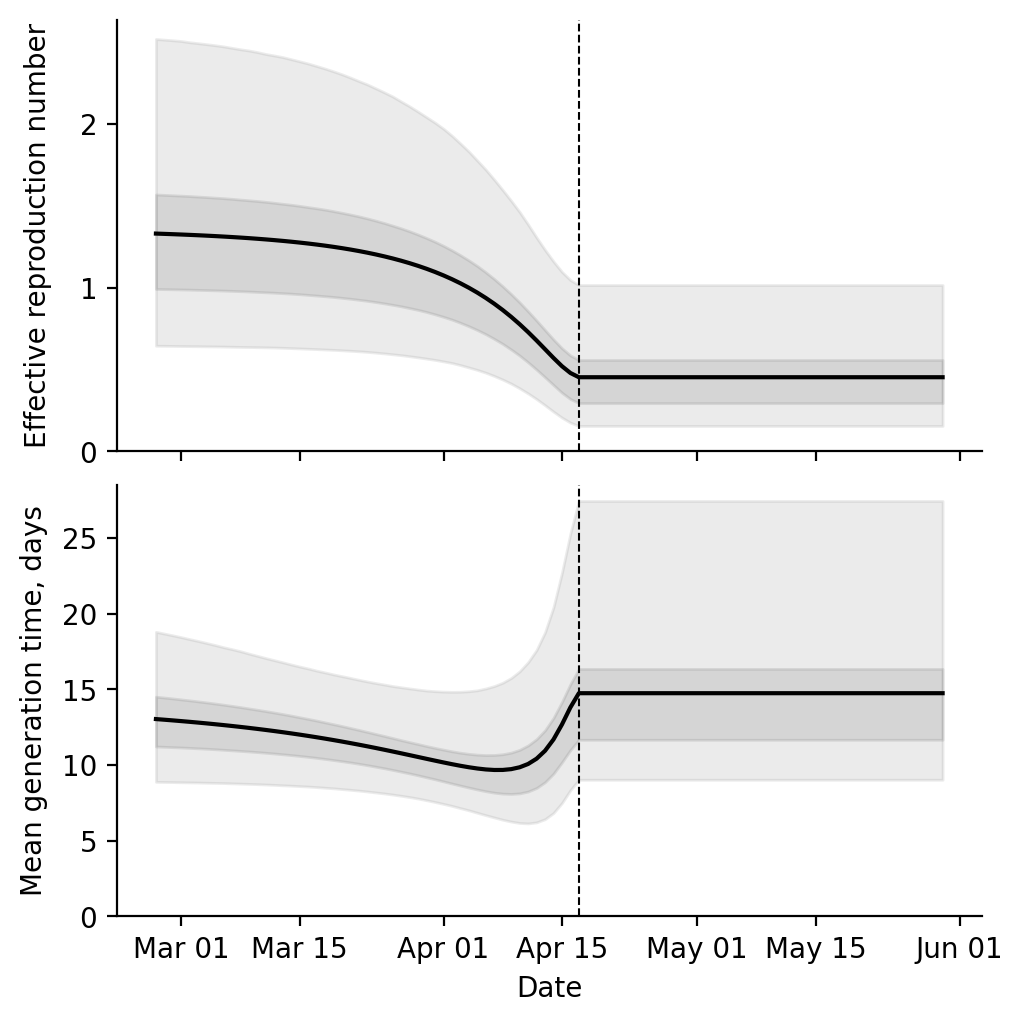

In [126]:
from matplotlib.dates import DateFormatter

fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True, figsize = [5, 5])

df_ = df_variation_in_time.loc[lambda d: d['var'] == 'gentime_mean_t'].copy()

ax1.plot(df_['date'], df_['mean'], c = 'k', lw = 1.5)
ax1.fill_between(df_['date'], df_['lower'], df_['upper'], color = 'C7', alpha = .15)
ax1.fill_between(df_['date'], df_['IQR_lower'], df_['IQR_upper'], color = 'C7', alpha = .2)
    
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.set_ylim(bottom = 0)
ax1.vlines(date_intervention, 0, ax1.get_ylim()[-1], color = 'k', ls = 'dashed', lw = .75)

ax1.set_xlabel('Date')
ax1.set_ylabel('Mean generation time, days', labelpad = 5)

ax1.xaxis.set_major_formatter(DateFormatter("%b %d"))

df_ = df_variation_in_time.loc[lambda d: d['var'] == 'R_t'].copy()

ax2.plot(df_['date'], df_['mean'], c = 'k', lw = 1.5)
ax2.fill_between(df_['date'], df_['lower'], df_['upper'], color = 'C7', alpha = .15)
ax2.fill_between(df_['date'], df_['IQR_lower'], df_['IQR_upper'], color = 'C7', alpha = .2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

xmn, xmx = ax2.get_xlim()
ax2.set_ylim(bottom = 0)
ytks = np.arange(0, 3, 1)
ax2.set_yticks(ytks)
# [ax2.hlines(ytk, xmn, xmx, color = 'C7', ls = 'dotted', lw = .2, zorder = -5) for ytk in ytks]
ax2.vlines(date_intervention, 0, ax2.get_ylim()[-1], color = 'k', ls = 'dashed', lw = .75)
ax2.set_xlim(xmn, xmx)

ax2.set_ylabel('Effective reproduction number', labelpad = 10);

plt.savefig(f"{figuresdir}/R_gentime_t.pdf", format="pdf", bbox_inches="tight")